In [1]:
import numpy as np
import scipy.io as sio
from scipy.sparse import lil_matrix
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import json
import csv

import time
from time import perf_counter
import sklearn.metrics as skmet

In [2]:
from SEER.seer import seer
import SEER.nntools as nnt

In [3]:
with open("./config.json") as c:
            config = json.load(c)
            #garden_points_db_path = config["garden_points_db"]
            #garden_points_matrix_path = config["garden_points_matrix"]
            #garden_query_points_path = config["garden_query_points"]
            #raw_data_db = config["raw_garden_points_db"]
            #raw_data_query = config["raw_garden_query_points"]
            
            
            garden_gt_data = config["garden_ground_truth"]
            garden_db_1_path = config["garden_points_db_bz"]
            garden_q_1_path = config["garden_query_points_bz"]
            
            garden_db_2_path = config["garden_points_db_pn"]
            garden_q_2_path = config["garden_query_points_pn"]
            
            nl_spring_path = config["nl_spring_seer"]
            nl_winter_path = config["nl_winter_seer"]

In [8]:
with open(garden_db_2_path, newline='') as csvfile:
    garden_DB_SEER_2 = np.array(list(csv.reader(csvfile)), dtype='float')
    
with open(garden_q_2_path, newline='') as csvfile:
    garden_Q_SEER_2 = np.array(list(csv.reader(csvfile)), dtype='float')

    
DS_garden_1 = sp.load_npz(garden_db_1_path)
Q_garden_1 = sp.load_npz(garden_q_1_path)

DS_garden_2 = sp.csr_matrix(garden_DB_SEER_2)
Q_garden_2 = sp.csr_matrix(garden_Q_SEER_2)

nl_spring_seer = sio.loadmat(nl_spring_path)['DB_SEER_run2']
nl_winter_seer = sio.loadmat(nl_winter_path)['Q_SEER']


In [30]:
def run_and_evaluate_func_on_data(function, dataX, dataY, datastring, functionstring, similarity_mode, *args):
    start = perf_counter()
    #call function with given data and optional arguments
    res_matrix = function(dataX, dataY, *args)
    end = perf_counter()
    duration = end - start
    #create a matrix where only the best match is set to 1 and all others to 0
    res_matrix_dist_hard = nnt.dist_principal_diagonal(nnt.calc_hard_matrix(res_matrix, similarity_mode))
    #create a matrix where the entries are the indices of the sorted NNs
    res_rank = nnt.get_position_of_correct_frame(res_matrix, similarity_mode)
    print_matrices(res_matrix, res_matrix_dist_hard, res_rank, datastring, functionstring, *args)
    
    #create a mask for the top 5 findings for each descriptor 
    mask = res_rank < 5
    #Sum the boolean mask to get the count of elements less than 5
    res_matrix_count_tolerated = np.sum(mask)
    print(f"Duration {functionstring}: {duration} seconds")
    print(f"Median Distance to GT-NN: {np.median(res_matrix_dist_hard)}")
    print(f"Average Distance to GT-NN: {np.mean(res_matrix_dist_hard)}")
    print(f"Median Rank of GT-NN: {np.median(res_rank)}")
    print(f"Average Rank of GT-NN: {np.mean(res_rank)}")
    print(f"{res_matrix_count_tolerated} out of {res_matrix.shape[0]} within top 5 NNs")
    return res_matrix, res_matrix_dist_hard, res_rank

def print_matrices(gs_mat, dist_hard, rank, datastring, functionstring, *args):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
    s = args
    fig.suptitle(f"Dataset:  {datastring},  Function:  {functionstring}, Parameters: {s}")
    x = np.arange(0, gs_mat.shape[0])
    im = ax1.imshow(gs_mat, cmap='gray')
    ax1.set_title("Grayscale Results")
    # Add colorbar to ax1
    cbar = fig.colorbar(im, ax=ax1)
    cbar.set_label('Pixel Intensity')  # Label for the colorbar
    
    values1, bins1, bars1 = ax2.hist(dist_hard, bins=[0, 1, 2, 3, 4, 5, 10, 20, 50, 200], edgecolor='white')
    ax2.bar_label(bars1, fontsize=10, color='navy')
    ax2.set_xscale('log')
    #ax2.scatter(x, dist_hard, s=1)
    ax2.set_title("Distance to correct NN (frames)")
    
    values2, bins2, bars2 = ax3.hist(rank, bins=[0, 1, 2, 3, 4, 5, 10, 20, 50, 200], edgecolor='white')
    ax3.bar_label(bars2, fontsize=10, color='navy')
    ax3.set_xscale('log')
    #ax3.scatter(x, rank, s=1)
    #ax3.axhline(y=5, color='r', linestyle='-')
    ax3.set_title("Index of correct frame in sorted NNs")
    
    s1 = (f"_{s}_").replace('(','').replace(')','').replace(", ",'_').replace('.','-')
    dir = "./exports/"
    
    # Save the full figure
    file_full = (f"{dir}00_{functionstring}_{s1}_{datastring}_full").replace(' ', '')
    fig.savefig(file_full)
    
def piDist_simple_sequential(Xin, Yin, p):
    # iterate over all points
    result_Matrix = np.zeros((Xin.shape[0], Yin.shape[0]), dtype=np.float32)
    highest_per_dim = np.amax(Xin, axis=0).toarray()[0]
    lowest_per_dim = nnt.get_lowest_per_dimension(Xin)
    range_per_dim = highest_per_dim - lowest_per_dim
    print("rpd: ", range_per_dim)
    for i in range(Xin.shape[0]):
        matrix1 = Xin[i]
        for j in range(Yin.shape[0]):
            matrix2 = Yin[j]
            common_indices = nnt.get_common_indices(matrix1, matrix2)
            valuesX, valuesY = nnt.get_values_on_common_dimension(matrix1, matrix2)
            
            
            differences = np.abs(valuesX - valuesY)
            frac = differences / range_per_dim[common_indices]
            temp_sum = np.sum( (1- frac)**p )
            similarity = (temp_sum)**(1/p)
            result_Matrix[j][i] = similarity
            if similarity < 0:
                print("i: ", i)
                print("j: ", j)
                print("frac: ", frac)
                print("temp_sum: ", temp_sum)
                print("similarity: ", similarity)
    return result_Matrix

In [38]:
Xin = DS_garden_1
Yin = Q_garden_1

result_Matrix = np.zeros((Xin.shape[0], Yin.shape[0]), dtype=np.float32)
highest_per_dim = np.amax(Xin, axis=0).toarray()[0]
lowest_per_dim = nnt.get_lowest_per_dimension(Xin)
range_per_dim = highest_per_dim - lowest_per_dim

In [48]:
nnt.get_common_indices(Xin[0], Yin[0])

array([ 1,  7, 18, 19, 27, 28, 29, 30, 31, 39, 40, 47], dtype=int32)

In [50]:
Xin[0,7]

0.10605590276912825

In [51]:
Yin[0,7]

0.017889202

In [52]:
range_per_dim[7]

0.07253463941213795

In [53]:
highest_per_dim[7]

0.10605590276912825

In [54]:
lowest_per_dim[7]

0.0335212633569903

In [37]:
dims = np.array([2,23,33,46,56,6000])
im[0, dims].toarray()[0]

array([0.09260082, 0.09763565, 0.10656231, 0.09840543, 0.        ,
       0.        ])

Duration PIDist without ranges: 761.7176152910106 seconds
Median Distance to GT-NN: 82.0
Average Distance to GT-NN: 183.225
Median Rank of GT-NN: 994.0
Average Rank of GT-NN: 960.713
12 out of 1000 within top 5 NNs


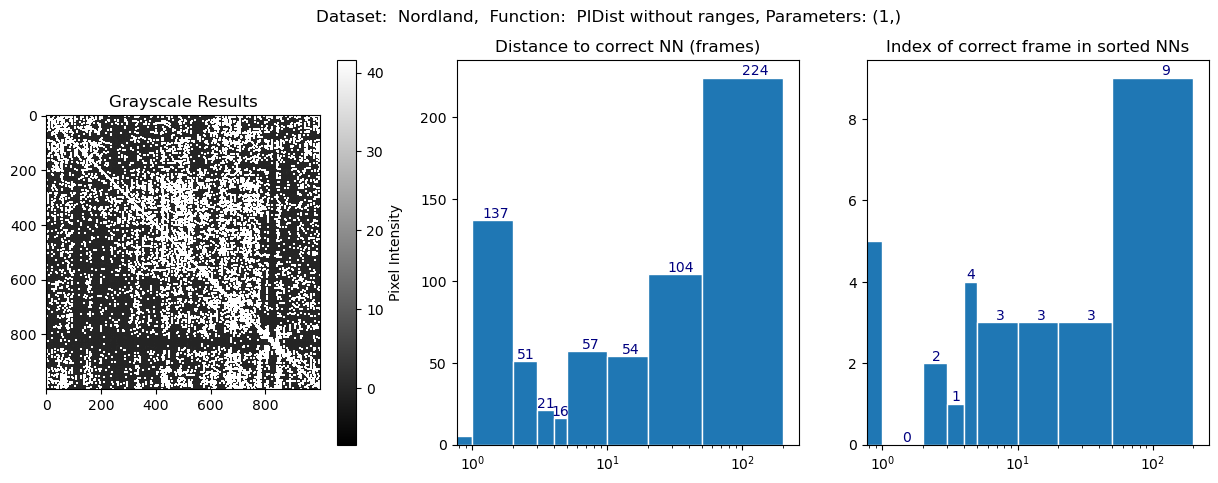

In [23]:
r, rdh, rr = run_and_evaluate_func_on_data(nnt.piDist_simple_sequential, nl_spring_seer, nl_winter_seer, "Nordland", "PIDist without ranges", True, 1)

rpd:  [0.07571867 0.07902919 0.0594957  ... 0.         0.         0.        ]
i:  0
j:  0
frac:  [0.99086267 1.21551168 1.05955348 0.98394282 0.97371741 1.22864033
 1.28203813 1.33402892 0.97870044 0.98093639 1.00950548 1.12649351]
temp_sum:  -1.1639312713622743
similarity:  -1.1639312713622743
i:  0
j:  1
frac:  [0.92516981 1.40367479 1.17851317 1.21062382 1.10805487 0.96994513
 0.93076279 1.19353208 1.23355429 1.17945109 1.24388989 0.97339769
 0.94592486 1.23467255 1.13979354]
temp_sum:  -1.8709603698043165
similarity:  -1.8709603698043165
i:  0
j:  2
frac:  [1.14410707 0.97315167]
temp_sum:  -0.11725873499909312
similarity:  -0.11725873499909312
i:  0
j:  3
frac:  [1.14066304 1.25120916]
temp_sum:  -0.39187220676632384
similarity:  -0.39187220676632384
i:  0
j:  4
frac:  [1.31320777 1.24060873 1.11880123]
temp_sum:  -0.6726177253846395
similarity:  -0.6726177253846395
i:  0
j:  8
frac:  [1.23283522]
temp_sum:  -0.232835220096973
similarity:  -0.232835220096973
i:  0
j:  21
frac:  [1

/var/folders/ps/mj99w1213zg0w0ymxdbjl9sr0000gn/T/ipykernel_848/3886736021.py:72: RuntimeWarning: divide by zero encountered in divide
  frac = differences / range_per_dim[common_indices]


i:  10
j:  89
frac:  [0.2881522  0.31822692 0.24888206 0.23889852 1.36273887 1.27726246
 1.01701067        inf 1.017109   0.96386655 1.17411158 1.22518759
 1.08506462 0.89746581]
temp_sum:  -inf
similarity:  -inf
i:  10
j:  91
frac:  [1.21999882]
temp_sum:  -0.21999882161459583
similarity:  -0.21999882161459583
i:  10
j:  96
frac:  [1.2096084]
temp_sum:  -0.20960840337445918
similarity:  -0.20960840337445918
i:  10
j:  117
frac:  [0.93985135 1.23629302]
temp_sum:  -0.17614437113429193
similarity:  -0.17614437113429193
i:  10
j:  148
frac:  [1.23984781]
temp_sum:  -0.23984780575907738
similarity:  -0.23984780575907738
i:  10
j:  165
frac:  [1.26994319 1.18117846]
temp_sum:  -0.4511216534297291
similarity:  -0.4511216534297291
i:  10
j:  169
frac:  [1.24611095]
temp_sum:  -0.24611094800456157
similarity:  -0.24611094800456157
i:  10
j:  186
frac:  [1.06933763]
temp_sum:  -0.06933762604231997
similarity:  -0.06933762604231997
i:  10
j:  199
frac:  [1.39766386]
temp_sum:  -0.39766386258548

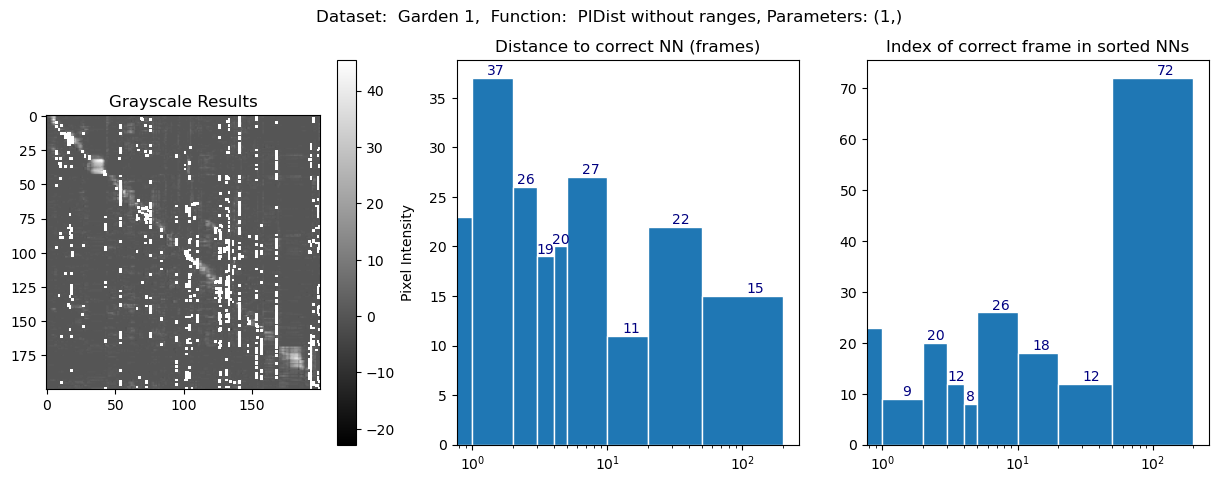

In [31]:
r, rdh, rr = run_and_evaluate_func_on_data(piDist_simple_sequential, DS_garden_1, Q_garden_1, "Garden 1", "PIDist without ranges", True, 1)

In [38]:
def print_gs_matrix(matrix):
    plt.imshow(matrix, cmap='gray')
    plt.colorbar()
    plt.show()

In [39]:
DB = sio.loadmat(raw_data_db)['Y']
Q_data = sio.loadmat(raw_data_query)['Y']
gt = sio.loadmat(garden_gt_data)['GT']['GThard'][0][0]

NameError: name 'raw_data_db' is not defined

In [40]:
print_gs_matrix(gt)

NameError: name 'gt' is not defined

In [7]:
M = None
k = 50
lambda_val = 2

In [9]:
#garden_seer.save_matrix_to_file(M, garden_points_matrix_path)
garden_seer.save_matrix_to_file(DS, garden_points_db_path)

In [10]:
Q = garden_seer.compute_seer_descriptors(Q_data, M, lambda_val, k)

In [11]:
garden_seer.save_matrix_to_file(Q, garden_query_points_path)

In [11]:
def sequential_cos_sim(db, q):
    #for x in range(db.shape[0]):
        #for y in range(q.shape[0]):
            #sim = skmet.pairwise.cosine_similarity(x,y)
    return skmet.pairwise.cosine_similarity(db,q)

In [13]:
cos_sim = sequential_cos_sim(DS, Q)

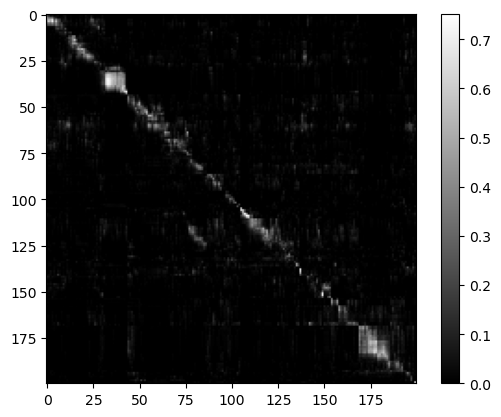

In [14]:
print_gs_matrix(cos_sim)

In [15]:
summer_raw = np.load('./data/nordland/raw/summer.npy')
spring_raw = np.load('./data/nordland/raw/spring.npy')

In [16]:
cos_sim_nl = sequential_cos_sim(summer_raw, spring_raw)

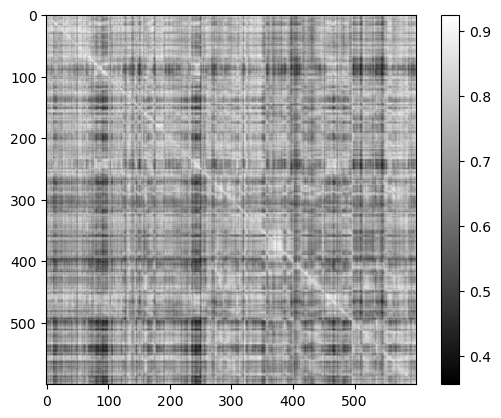

In [17]:
print_gs_matrix(cos_sim_nl)

In [16]:
summer_mat = sp.load_npz(nl_summer_mat_path)
summer_seer = sp.load_npz(nl_summer_seer_path)

In [17]:
winter_raw = np.load(nl_winter_raw_path)

In [19]:
nl_summer_seer = seer()
Q_winter = nl_summer_seer.compute_seer_descriptors(winter_raw, summer_mat, lambda_val, k)

In [ ]:
nl_summer_seer.save_matrix_to_file(M_summer, nl_summer_mat_path)


In [21]:
summer_seer

<600x50 sparse matrix of type '<class 'numpy.float64'>'
	with 30000 stored elements in Compressed Sparse Row format>

In [22]:
cos_sim_nl = sequential_cos_sim(summer_seer, summer_seer)

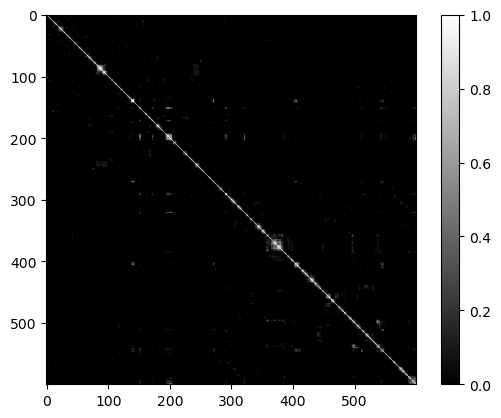

In [23]:
print_gs_matrix(cos_sim_nl)

In [12]:
def calc_hard_matrix(matrix):
    # Find the indices of the maximum values in each row
    max_indices = np.argmax(matrix, axis=1)

    # Create a new matrix with the same shape, filled with zeros
    result = np.zeros_like(matrix)

    # Set the maximum values to 1
    result[np.arange(matrix.shape[0]), max_indices] = 1
    return result

def print_gs_matrix_hard(matrix):
    result = calc_hard_matrix(matrix)
    plt.imshow(result, cmap='gray')
    plt.colorbar()
    plt.show()

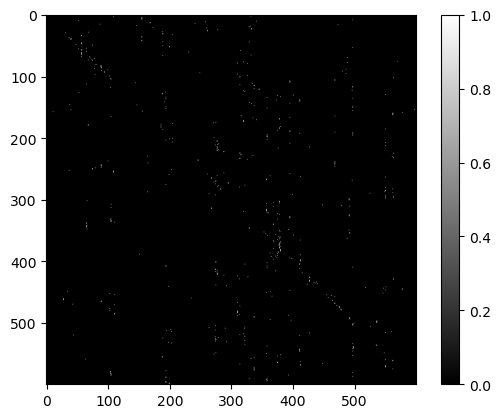

In [25]:
print_gs_matrix_hard(cos_sim_nl)

In [27]:
differences_nl_summer = np.zeros(600)
for i in range(cos_sim_nl.shape[0]):
    difference = np.abs(np.argmax(cos_sim_nl[i]) - i)
    differences_nl_summer[i] = difference 

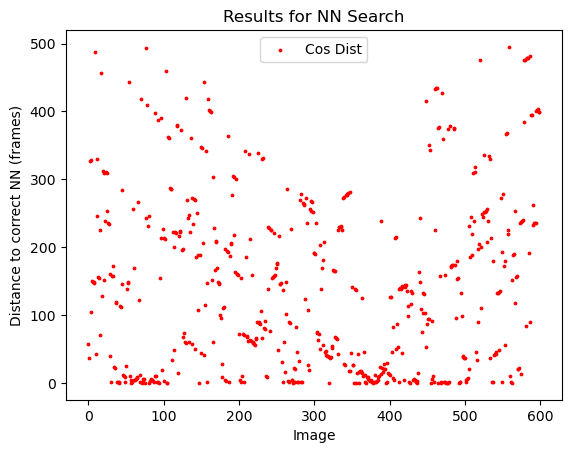

In [30]:
X = np.arange(0, 600)

plt.scatter(X, differences_nl_summer, color='r', s=3, label='Cos Dist')

plt.xlabel("Image")
plt.ylabel("Distance to correct NN (frames)")
plt.title("Results for NN Search")

plt.legend()
plt.show()

In [9]:
spring_seer = sp.load_npz(nl_spring_seer_path)
q_winter = sp.load_npz('./data/nordland/seer/q_winter_m_spring.npz')

In [13]:
cos_sim_nl = sequential_cos_sim(spring_seer, q_winter)

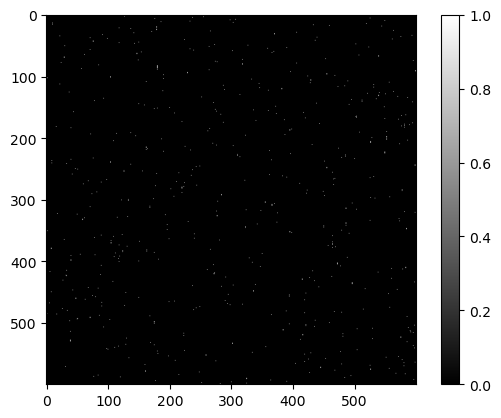

In [15]:
print_gs_matrix_hard(cos_sim_nl)

In [6]:
def get_lowest_per_dimension(matrix):
    arr_with_inf = np.where(matrix.toarray() == 0, np.inf, matrix.toarray())
    lowest_per_dim = np.amin(arr_with_inf, axis=0)
    return lowest_per_dim

In [7]:
def get_common_indices(sparsem1, sparsem2):
    return np.intersect1d(sparsem1.nonzero()[1],  sparsem2.nonzero()[1]) #common_indices

def get_values_on_common_dimension(sparsem1, sparsem2):
    common_indices = get_common_indices(sparsem1, sparsem2)
    
    common_values1 = sparsem1[0, common_indices].toarray()[0]
    common_values2 = sparsem2[0, common_indices].toarray()[0]
    return common_values1, common_values2

In [8]:
def piDist_sequential(Xin, Yin, p):
    # iterate over all points
    result_Matrix = np.zeros((Xin.shape[0], Yin.shape[0]), dtype=np.float32)
    highest_per_dim = np.amax(Xin, axis=0).toarray()
    lowest_per_dim = get_lowest_per_dimension(Xin)
    range_per_dim = highest_per_dim - lowest_per_dim
    
    
    for i in range(Xin.shape[0]):
        matrix1 = Xin[i]
        for j in range(Yin.shape[0]):
            if i > j:
                similarity = result_Matrix[i][j]
            else:
                matrix2 = Yin[j]
                # get common dimensions
                common_indices = get_common_indices(matrix1, matrix2)
                valuesX, valuesY = get_values_on_common_dimension(matrix1, matrix2)
                differences = np.abs(valuesX - valuesY)
                similarity = (np.sum( (1- differences / range_per_dim[common_indices])**p ))** (1/p)
            result_Matrix[j][i] = similarity
    return result_Matrix

In [14]:
#get dimension ranges
l = get_lowest_per_dimension(DS_garden_1)
h = np.amax(DS_garden_1, axis=0).toarray()[0]
r = h-l
# set threshold
t = 0.5 # the smaller, the closer the values
#i = j = 5
c_i = get_common_indices(DS_garden_1[5], Q_garden_1[5])
vx, vy = get_values_on_common_dimension(DS_garden_1[5], Q_garden_1[5])
d = np.abs(vx - vy)

#get indices of differences close enough



In [44]:
close_indices = np.where(d < (r[c_i]*0.5))
c_i_close = c_i[close_indices]
d_close = d[close_indices]

In [43]:
c_i_close

array([ 54,  55,  56,  57,  61,  66,  67,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  84,  85,  86,  88,  89,
        92,  93,  94,  95,  96,  97,  98, 101, 105, 106, 112, 113],
      dtype=int32)

In [46]:
s = (np.sum( (1- d_close / r[c_i_close])**1 ))** (1/1)
s

30.79501463636202

In [36]:
r[c_i]*0.5

array([0.02742228, 0.03477766, 0.03349487, 0.03228088, 0.02964715,
       0.04324874, 0.02947667, 0.03197057, 0.03764123, 0.03189306,
       0.04402957, 0.03275889, 0.03638085, 0.02973879, 0.03779966,
       0.03190078, 0.03695591, 0.03365923, 0.030655  , 0.0373721 ,
       0.04021779, 0.04112111, 0.04032985, 0.0470298 , 0.03666158,
       0.04310016, 0.0329174 , 0.02571981, 0.03126749, 0.03574511,
       0.03445101, 0.03494717, 0.03481084, 0.02446002, 0.0417201 ,
       0.03094218, 0.02966282, 0.03414289, 0.03356488, 0.0274653 ,
       0.02973886, 0.02853637, 0.03725466, 0.03288536, 0.03306195,
       0.0365214 , 0.03216328, 0.0375707 , 0.02154627, 0.0395808 ,
       0.03235391, 0.03940465])

Duration Cosinus distance: 0.005195333971641958 seconds


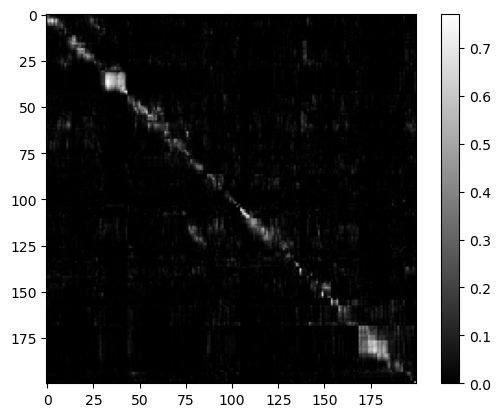

In [47]:
start = perf_counter()
cos_sim_garden_bz = skmet.pairwise.cosine_similarity(DS_garden_1, Q_garden_1)
end = perf_counter()
duration = end - start
print(f"Duration Cosinus distance: {duration} seconds")
nnt.print_gs_matrix(cos_sim_garden_bz)

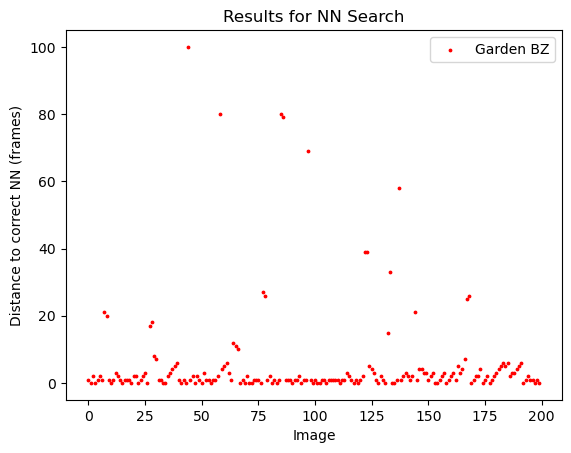

In [48]:
cos_sim_garden_bz_dist_hard = nnt.dist_principal_diagonal(nnt.calc_hard_matrix_similarity(cos_sim_garden_bz))
nnt.print_array_scatter(cos_sim_garden_bz_dist_hard, "Garden BZ", "Distance to correct NN (frames)")

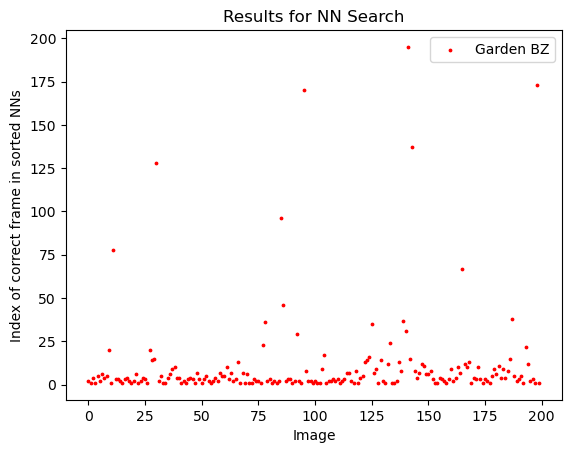

In [49]:
cos_sim_garden_bz_rank = nnt.get_position_of_correct_frame(cos_sim_garden_bz)
nnt.print_array_scatter(cos_sim_garden_bz_rank, "Garden BZ", "Index of correct frame in sorted NNs")

In [50]:
mask = cos_sim_garden_bz_rank < 5

# Sum the boolean mask to get the count of elements less than 5
cos_sim_garden_bz_count_tolerated = np.sum(mask)
print(cos_sim_garden_bz_count_tolerated)

119


Text(0.5, 1.0, 'Index of correct frame in sorted NNs')

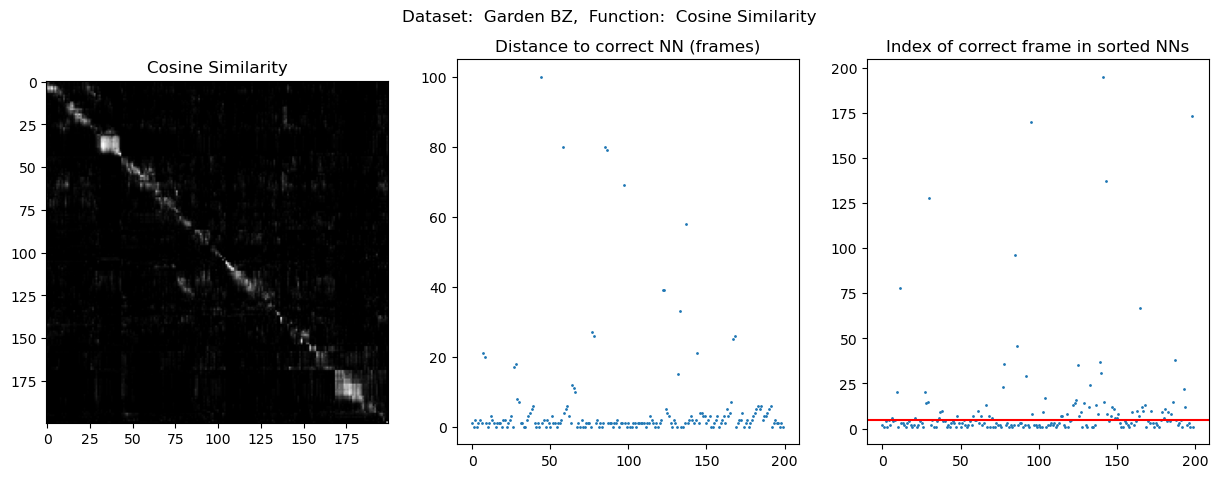

In [65]:
#cos_sim_garden_bz
data = "Garden BZ"
function = "Cosine Similarity"

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))


fig.suptitle(f"Dataset:  {data},  Function:  {function}")
#x = np.linspace(cos_sim_garden_bz_dist_hard.shape[0])
x = np.arange(0, cos_sim_garden_bz.shape[0])
ax1.imshow(cos_sim_garden_bz, cmap='gray')
ax1.set_title("Cosine Similarity")

ax2.scatter(x, cos_sim_garden_bz_dist_hard, s=1)
ax2.set_title("Distance to correct NN (frames)")
ax3.scatter(x, cos_sim_garden_bz_rank, s=1)
ax3.axhline(y=5, color='r', linestyle='-')
ax3.set_title("Index of correct frame in sorted NNs")

In [26]:
def print_matrices(gs_mat, dist_hard, rank, datastring, functionstring):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
    fig.suptitle(f"Dataset:  {datastring},  Function:  {functionstring}")
    x = np.arange(0, gs_mat.shape[0])
    ax1.imshow(gs_mat, cmap='gray')
    ax1.set_title("Grayscale Results")

    
    values1, bins1, bars1 = ax2.hist(dist_hard, bins=[0, 1, 2, 3, 4, 5, 10, 20, 50, 200], edgecolor='white')
    ax2.bar_label(bars1, fontsize=10, color='navy')
    ax2.set_xscale('log')
    #ax2.scatter(x, dist_hard, s=1)
    ax2.set_title("Distance to correct NN (frames)")
    
    
    values2, bins2, bars2 = ax3.hist(rank, bins=[0, 1, 2, 3, 4, 5, 10, 20, 50, 200], edgecolor='white')
    ax3.bar_label(bars2, fontsize=10, color='navy')
    ax3.set_xscale('log')
    #ax3.scatter(x, rank, s=1)
    #ax3.axhline(y=5, color='r', linestyle='-')
    ax3.set_title("Index of correct frame in sorted NNs")

def run_function_on_dataset(function, dataX, dataY, datastring, functionstring, *args):
    start = perf_counter()
    res_matrix = function(dataX, dataY, *args)
    end = perf_counter()
    duration = end - start
    res_matrix_dist_hard = nnt.dist_principal_diagonal(nnt.calc_hard_matrix_similarity(res_matrix))
    res_rank = nnt.get_position_of_correct_frame(res_matrix)
    print_matrices(res_matrix, res_matrix_dist_hard, res_rank, datastring, functionstring)
    
    mask = res_rank < 5
    # Sum the boolean mask to get the count of elements less than 5
    res_matrix_count_tolerated = np.sum(mask)
      
    print(f"Duration {functionstring}: {duration} seconds")
    print(f"{res_matrix_count_tolerated} out of {res_matrix.shape[0]} within top 5 NNs")
    return res_matrix, res_matrix_dist_hard, res_rank

In [55]:
def runfunc(func, *kwargs):
    s = kwargs
    s1 = (f"_{s}_").replace('(','').replace(')','').replace(", ",'_')
    print(s1)
    #func(*kwargs)
    return

In [56]:
def double(x, y):
    print(2*x, 2*y)
    return

In [57]:
runfunc(double, 2, 3)

_2_3_


Duration Cosine Sim: 0.004012875026091933 seconds
119 out of 200 within top 5 NNs


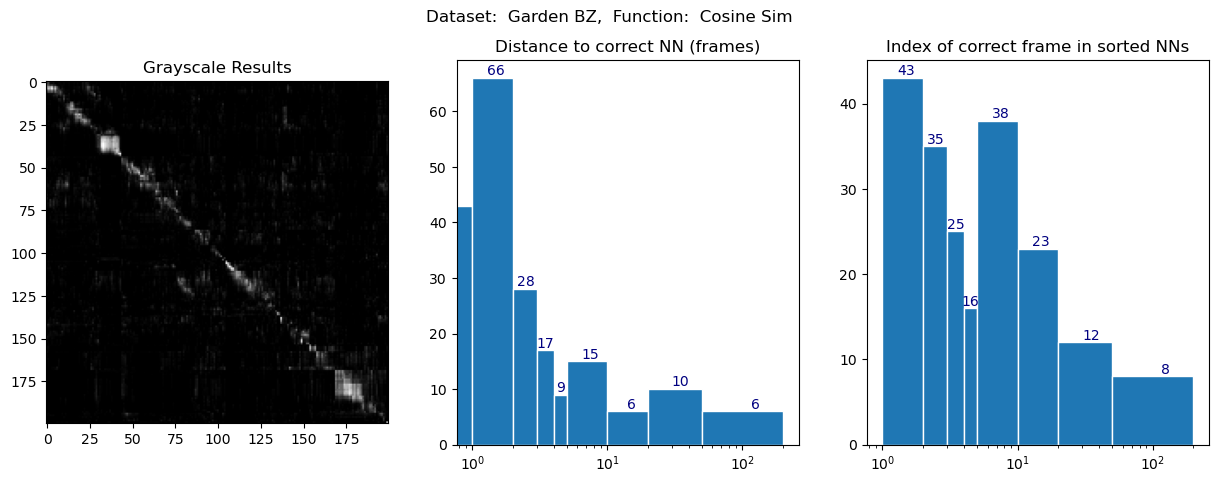

In [27]:
r, rdh, rr = run_function_on_dataset(skmet.pairwise.cosine_similarity, DS_garden_1, Q_garden_1, "Garden BZ", "Cosine Sim")

Duration Count Matching Dimensions: 1.609059625014197 seconds
133 out of 200 within top 5 NNs


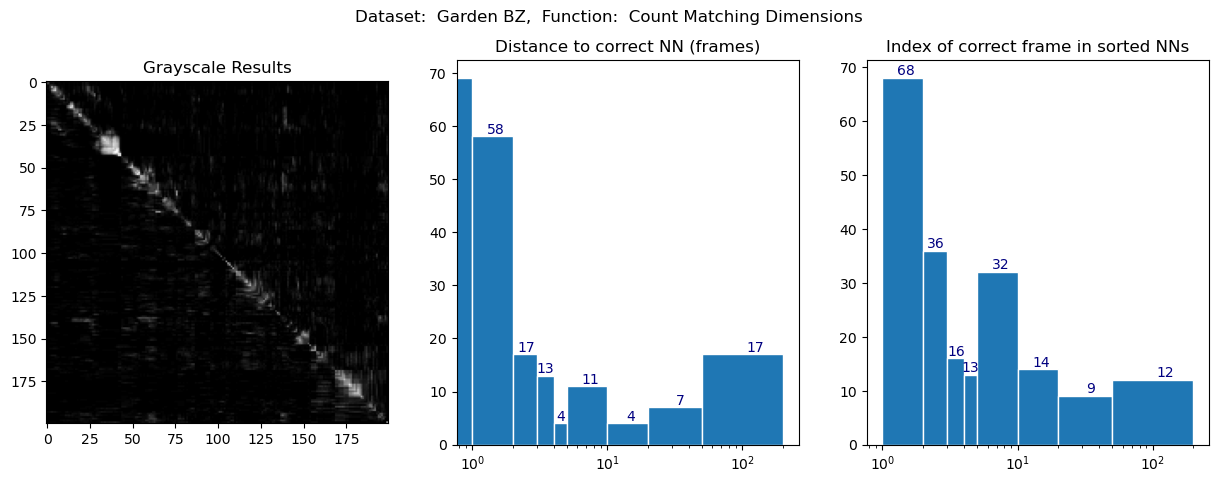

In [29]:
_, _, _ = run_function_on_dataset(nnt.compute_matching_dimensions_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "Count Matching Dimensions")

/Users/bz/ma-nearest-neighbours/code/SEER/nntools.py:172: RuntimeWarning: divide by zero encountered in divide
  similarity = (np.sum( (1- differences / range_per_dim[common_indices])**p ))** (1/p)


Duration PIDist simple: 3.6057377500110306 seconds
87 out of 200 within top 5 NNs


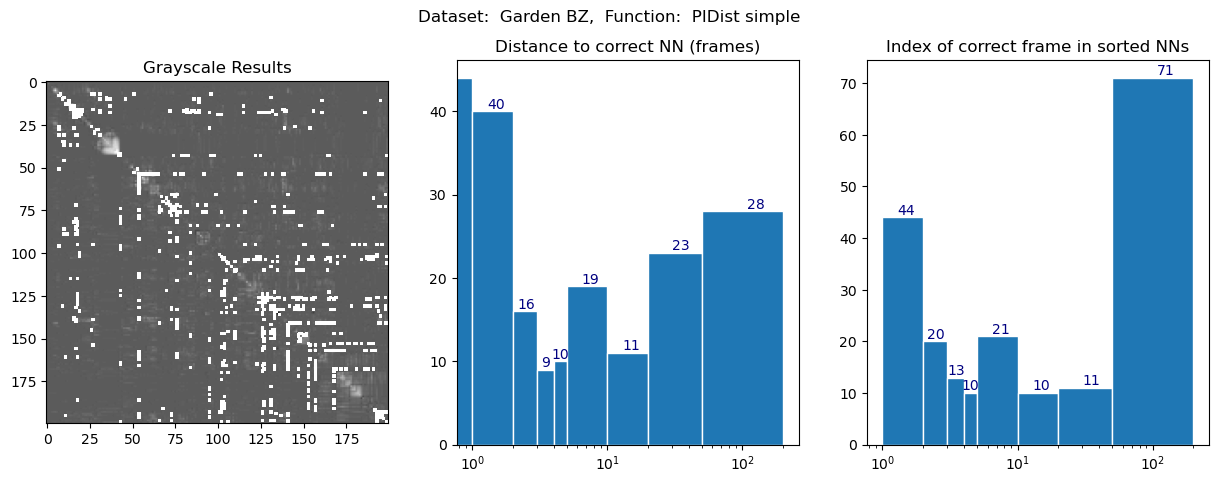

In [30]:
_, _, _ = run_function_on_dataset(nnt.piDist_simple_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "PIDist simple",1)

Duration PIDist simple: 3.6184299580054358 seconds
106 out of 200 within top 5 NNs


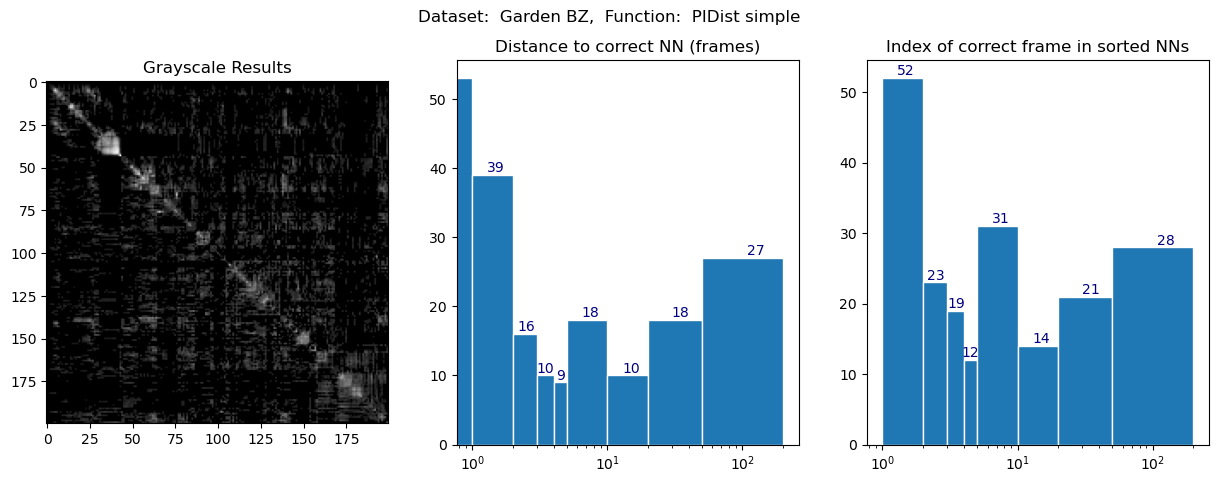

In [31]:
_, _, _ = run_function_on_dataset(nnt.piDist_threshold_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "PIDist simple",2, 0.5)

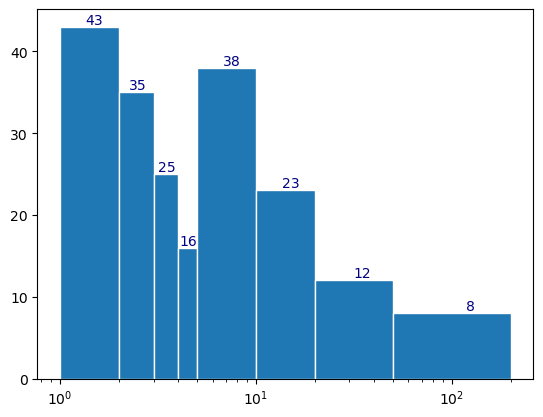

In [17]:
values, bins, bars = plt.hist(rr, bins=[0, 1, 2, 3, 4, 5, 10, 20, 50, 200], edgecolor='white')
plt.bar_label(bars, fontsize=10, color='navy')

plt.xscale('log')


#plt.hist(rr)
plt.show()

In [5]:
def create_multivariate_vectors(d, n):
    # Dimension d des Vektors
    #d = 3  # Beispiel mit 3 Dimensionen

    # Erwartungswert (Mittelwert) Vektor μ
    mu = np.zeros(d)  # Beispiel: 0-Vektor der Länge d

    # Kovarianzmatrix Σ (hier: I_d, die Einheitsmatrix)
    cov_matrix = np.eye(d)  # Identitätsmatrix der Größe d x d

    # Anzahl der zu generierenden Vektoren
    n = 5

    # Generiere n Vektoren aus der multivariaten Normalverteilung
    samples = np.random.multivariate_normal(mu, cov_matrix, n)
    return samples

In [7]:
create_multivariate_vectors(7123, 500)

array([[-0.9860485 , -1.03506948, -1.17501292, ...,  0.37257488,
         0.35071674, -0.45670478],
       [ 0.20598357,  0.25313747, -0.44347997, ...,  0.3413319 ,
        -0.14135755, -1.27871574],
       [-0.05693017, -1.39113813, -2.51354467, ..., -0.43813644,
        -0.81508076, -0.17922584],
       [ 0.6415685 , -0.9937171 ,  1.70071171, ..., -1.92355667,
         0.68528672, -0.22534072],
       [ 0.79149847,  0.53372786,  0.98208341, ..., -1.09610285,
         2.56411703,  1.37535468]])

In [6]:
from scipy.spatial import distance
def srp_lsh_sequential(Xin, Yin, num_rand_vectors):
    result_Matrix = np.zeros((Xin.shape[0], Yin.shape[0]), dtype=np.float32)
    d = Xin.shape[1]
    mu = np.zeros(d)
    cov_matrix = np.eye(d)
    rand_vectors = np.random.multivariate_normal(mu, cov_matrix, num_rand_vectors)
    for i in range(Xin.shape[0]):
        vec1 = Xin[i].toarray()
        for j in range(Yin.shape[0]):
            if i > j:
                similarity = result_Matrix[i][j]
            else:
                #compute similarity
                vec2 = Yin[j].toarray()
                code1 = (np.dot(vec1, np.transpose(rand_vectors)) >= 0)[0]
                code2 = (np.dot(vec2, np.transpose(rand_vectors)) >= 0)[0]
                similarity = distance.hamming(code1, code2)
            result_Matrix[j][i] = similarity
    return result_Matrix

In [7]:
x = DS_garden_1[6].toarray()
y = Q_garden_1[6].toarray()
d = DS_garden_1.shape[1]
mu = np.zeros(d)
cov_matrix = np.eye(d)
rand_vectors = np.random.multivariate_normal(mu, cov_matrix, 10)

In [23]:
code1 = (np.dot(x, np.transpose(rand_vectors)) >= 0)[0]
code2 = (np.dot(y, np.transpose(rand_vectors)) >= 0)[0]

In [ ]:
distance.hamming(code1, code2)

Duration SRP_LSH: 85.27015675010625 seconds
Median Distance to GT-NN: 10.5
Average Distance to GT-NN: 37.11
Median Rank of GT-NN: 14.5
Average Rank of GT-NN: 36.49
57 out of 200 within top 5 NNs


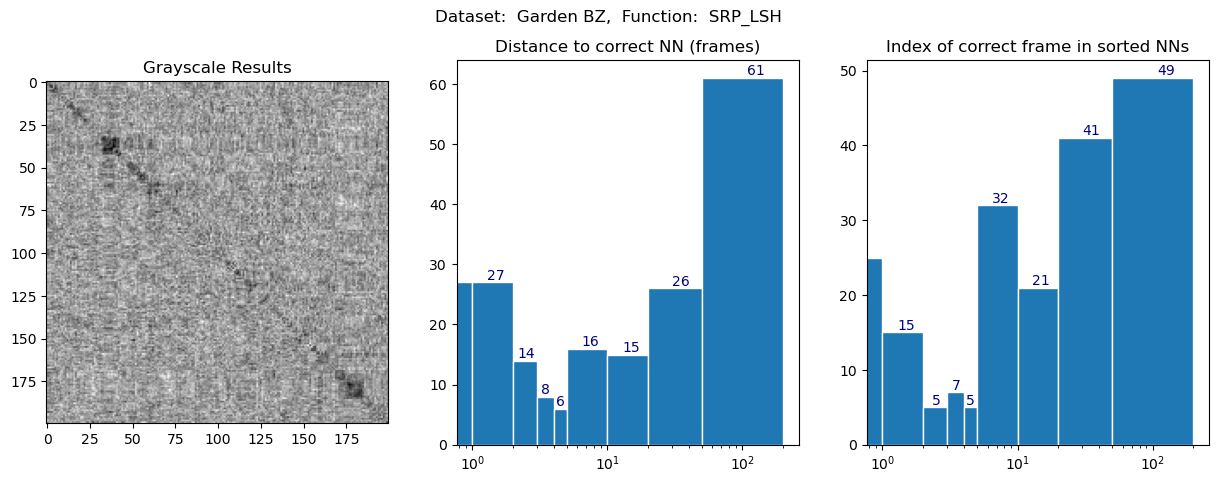

In [8]:
srp21, srp22, srp23 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "SRP_LSH", False, 100)

Duration SRP_LSH: 114.6703274169704 seconds
Median Distance to GT-NN: 10.0
Average Distance to GT-NN: 38.155
Median Rank of GT-NN: 24.0
Average Rank of GT-NN: 51.1
63 out of 200 within top 5 NNs


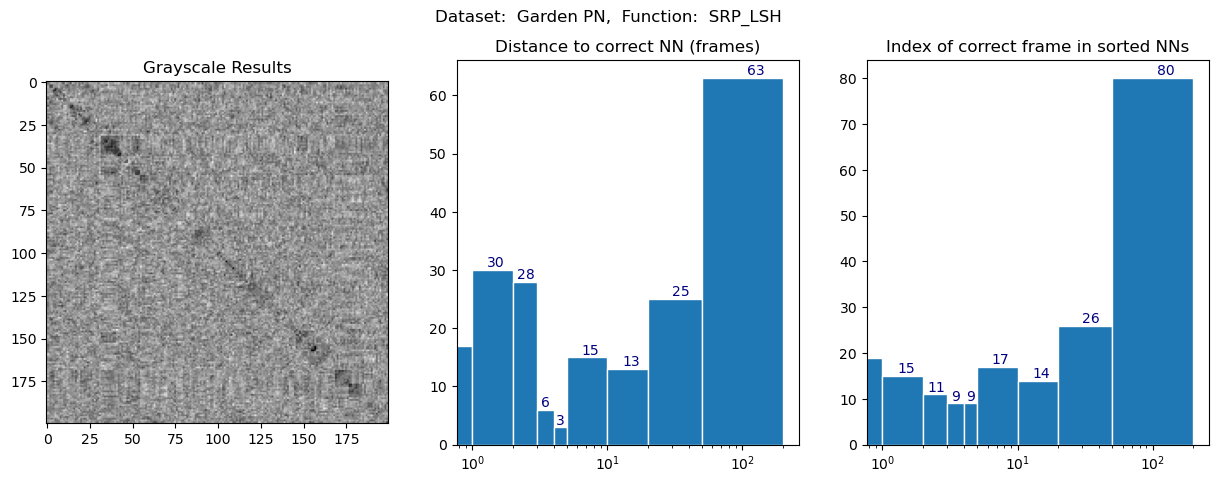

In [18]:
srp21pn, srp22pn, srp23pn = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_2, Q_garden_2, "Garden PN", "SRP_LSH", False, 100)

Duration SRP_LSH: 94.49671904102433 seconds
Median Distance to GT-NN: 34.5
Average Distance to GT-NN: 48.02
Median Rank of GT-NN: 29.0
Average Rank of GT-NN: 47.335
45 out of 200 within top 5 NNs


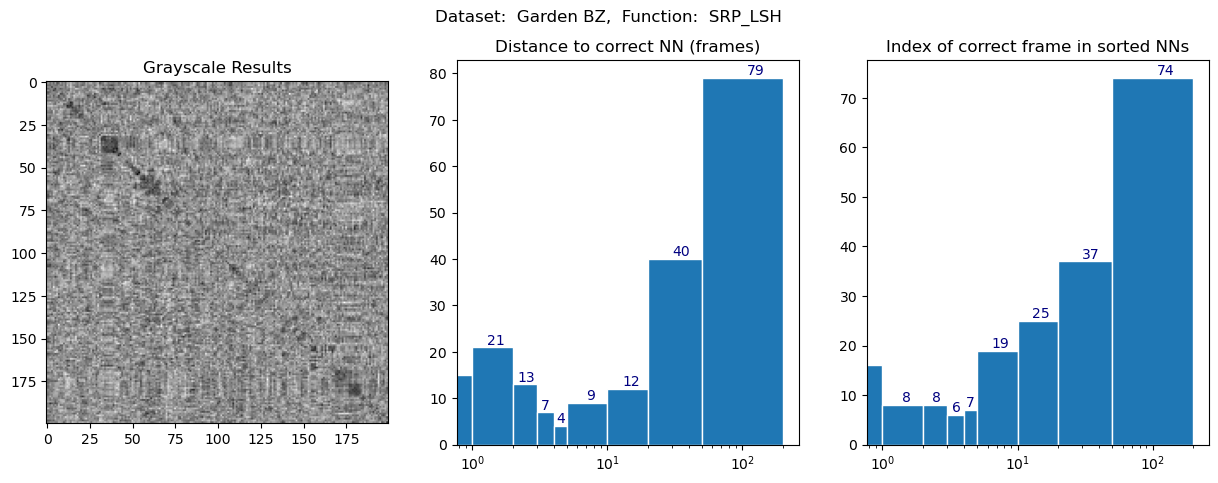

In [19]:
srp31, srp32, srp33 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "SRP_LSH", False, 50)

Duration SRP_LSH: 76.69798575004097 seconds
Median Distance to GT-NN: 4.0
Average Distance to GT-NN: 29.655
Median Rank of GT-NN: 12.0
Average Rank of GT-NN: 36.75
82 out of 200 within top 5 NNs


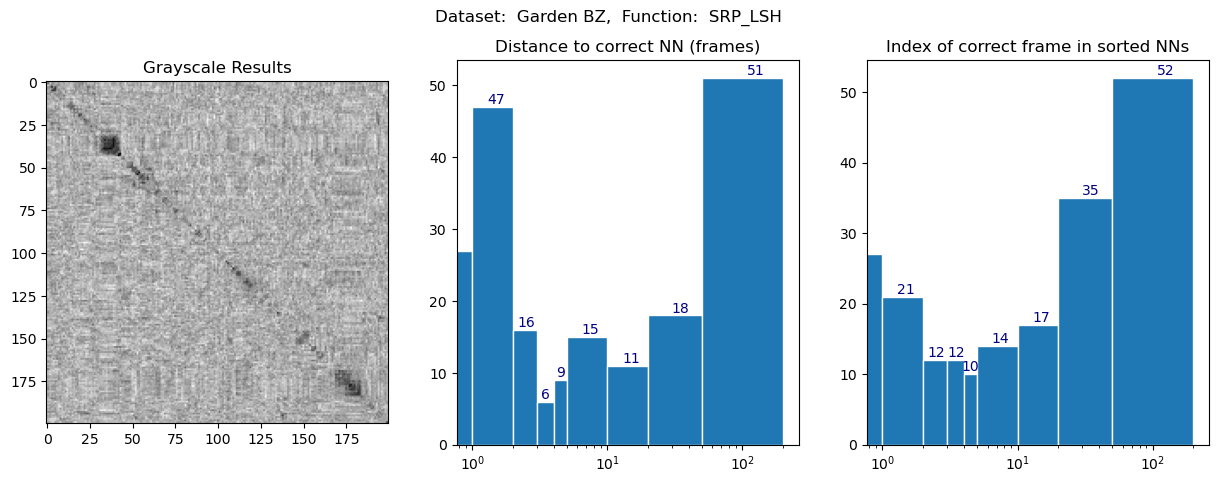

In [20]:
srp11, srp12, srp13 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "SRP_LSH", False, 200)

Duration SRP_LSH: 88.36516416701488 seconds
Median Distance to GT-NN: 2.0
Average Distance to GT-NN: 18.695
Median Rank of GT-NN: 5.0
Average Rank of GT-NN: 29.475
91 out of 200 within top 5 NNs


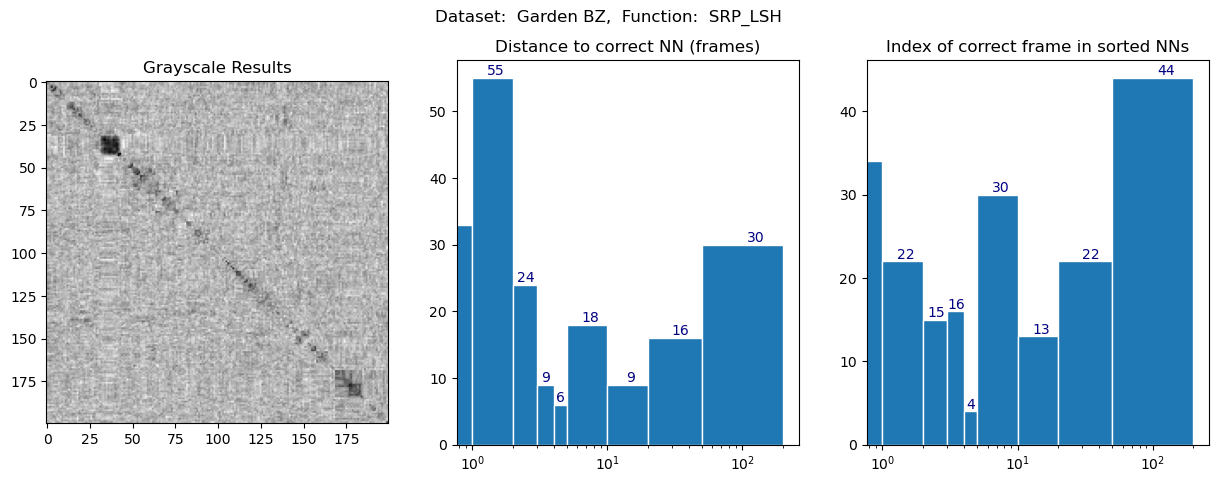

In [21]:
srp41, srp42, srp43 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "SRP_LSH", False, 360)

Duration SRP_LSH: 88.54029533301946 seconds
Median Distance to GT-NN: 2.0
Average Distance to GT-NN: 15.145
Median Rank of GT-NN: 3.0
Average Rank of GT-NN: 26.275
108 out of 200 within top 5 NNs


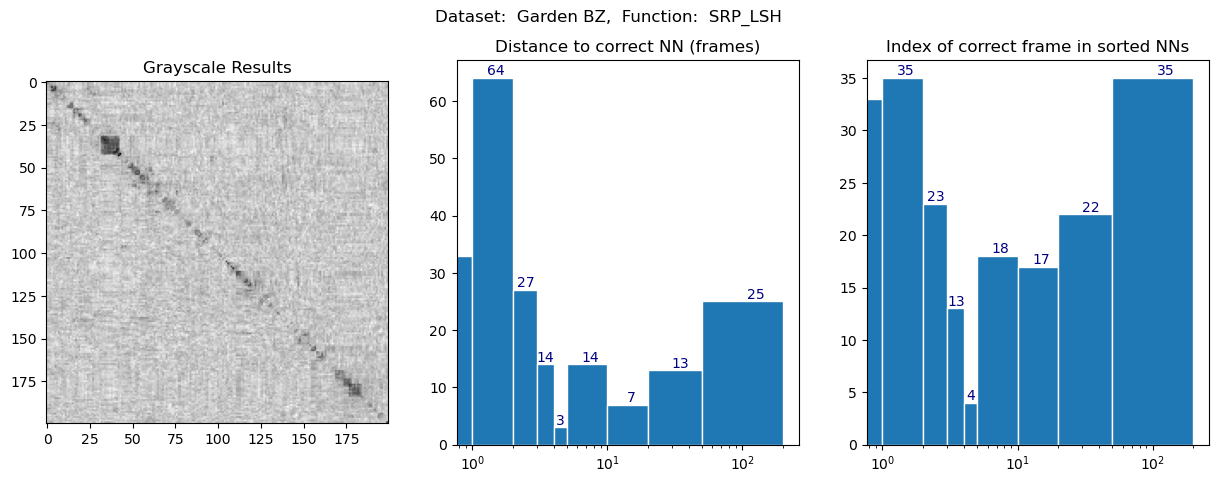

In [22]:
srp51, srp52, srp53 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "SRP_LSH", False, 540)

Duration SRP_LSH: 99.69758262508549 seconds
Median Distance to GT-NN: 2.0
Average Distance to GT-NN: 13.535
Median Rank of GT-NN: 3.5
Average Rank of GT-NN: 21.65
110 out of 200 within top 5 NNs


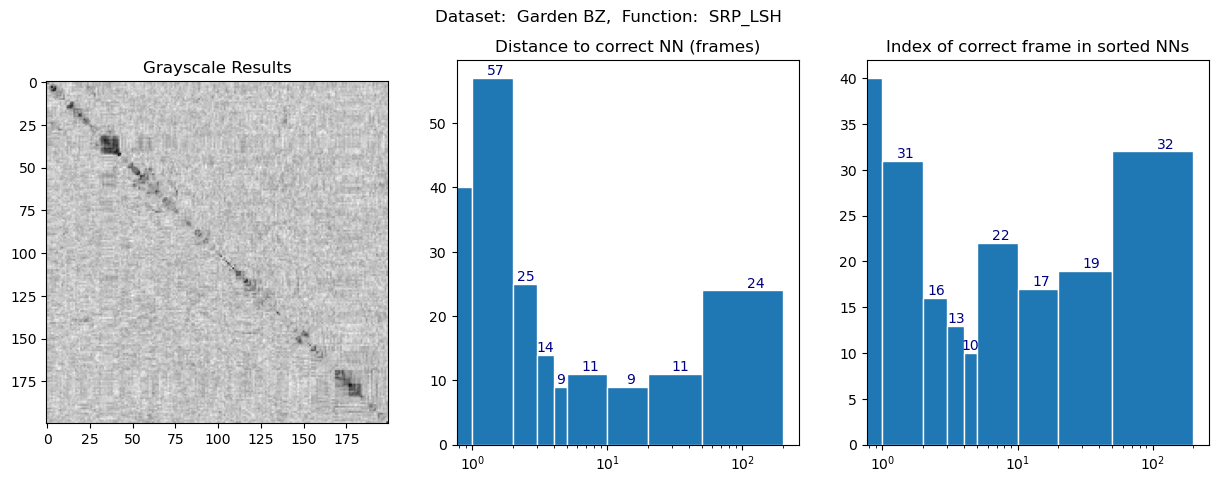

In [23]:
srp61, srp62, srp63 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "SRP_LSH", False, 720)

Duration SRP_LSH: 115.28313091699965 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 11.13
Median Rank of GT-NN: 3.0
Average Rank of GT-NN: 22.82
121 out of 200 within top 5 NNs


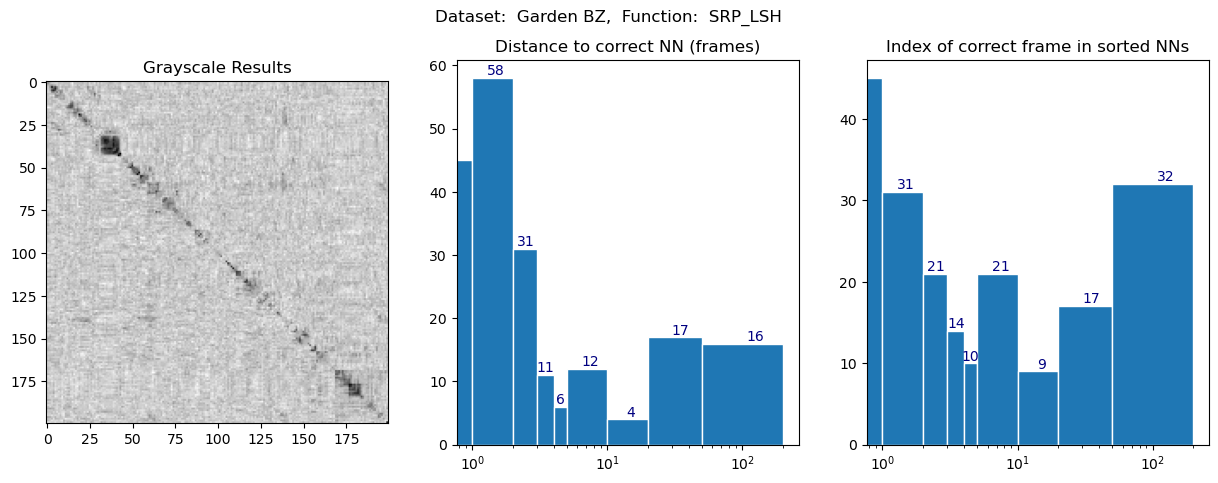

In [24]:
srp71, srp72, srp73 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "SRP_LSH", False, 900)

Duration SRP_LSH: 124.96686325001065 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 13.93
Median Rank of GT-NN: 3.0
Average Rank of GT-NN: 20.53
121 out of 200 within top 5 NNs


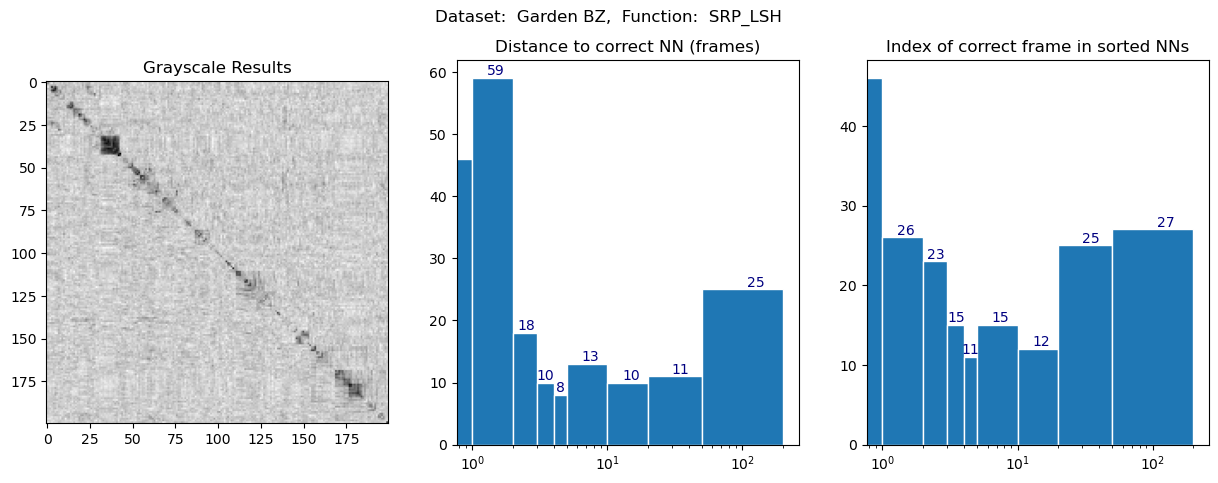

In [25]:
srp81, srp82, srp83 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "SRP_LSH", False, 1080)

Duration SRP_LSH: 148.42669824999757 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 11.645
Median Rank of GT-NN: 3.0
Average Rank of GT-NN: 24.26
119 out of 200 within top 5 NNs


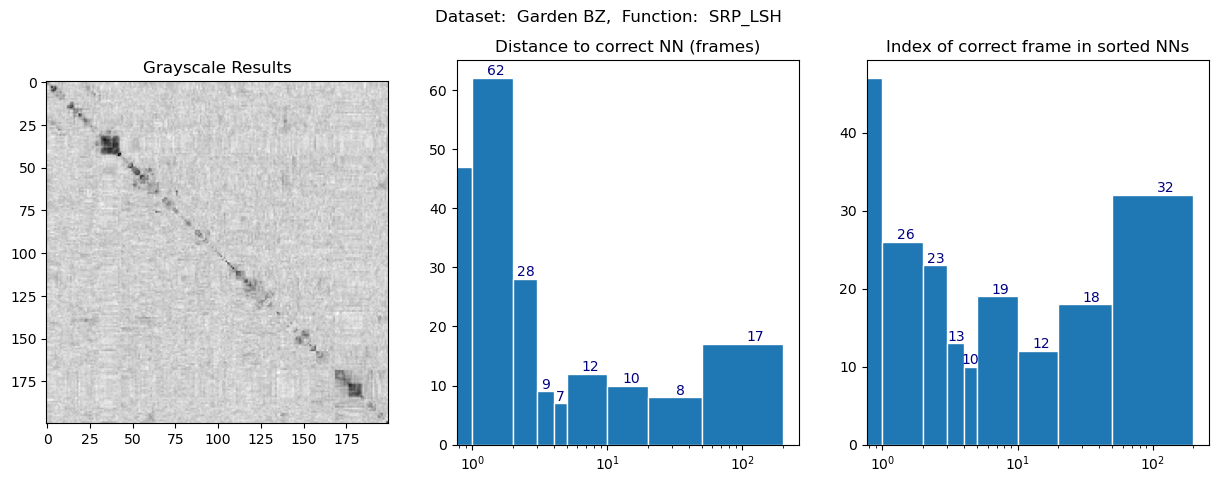

In [26]:
srp91, srp92, srp93 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "SRP_LSH", False, 1260)

Duration SRP_LSH: 215.0677414170932 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 11.925
Median Rank of GT-NN: 2.0
Average Rank of GT-NN: 17.35
134 out of 200 within top 5 NNs


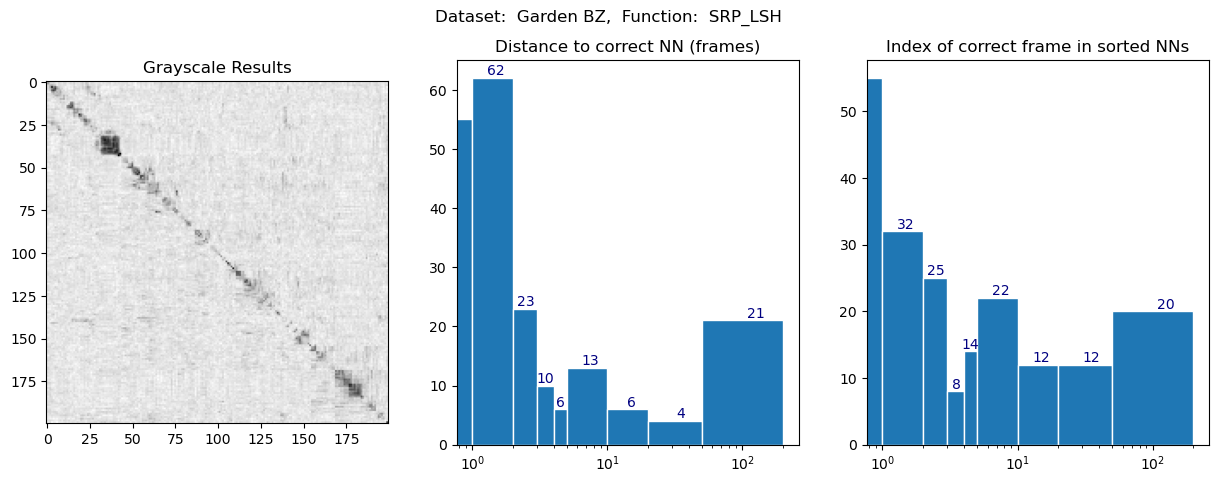

In [27]:
srp101, srp102, srp103 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "SRP_LSH", False, 3600)

Duration SRP_LSH: 270.24088649998885 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 9.18
Median Rank of GT-NN: 2.0
Average Rank of GT-NN: 16.19
131 out of 200 within top 5 NNs


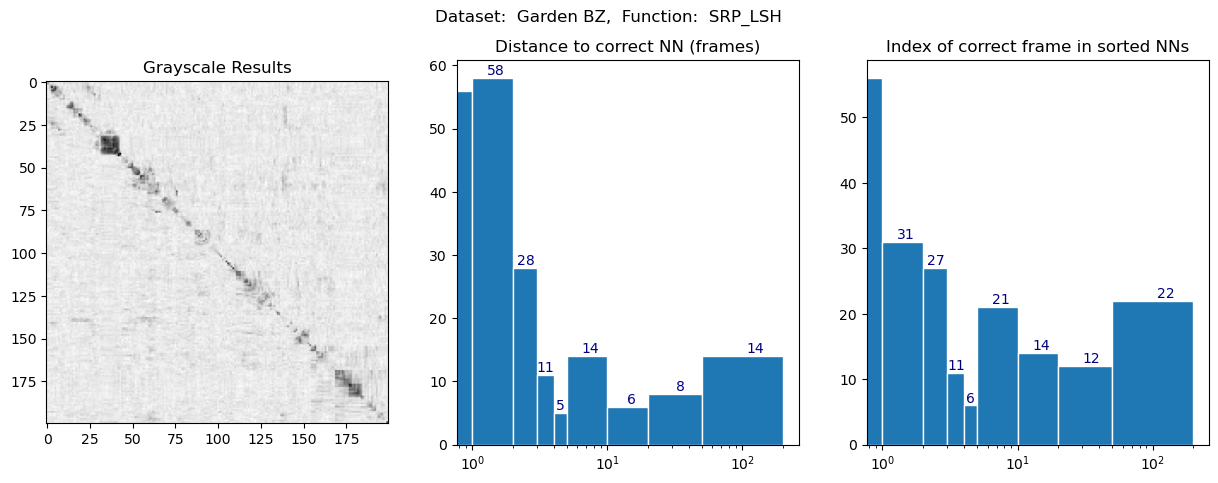

In [28]:
srp111, srp112, srp113 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_1, Q_garden_1, "Garden BZ", "SRP_LSH", False, 5400)

Duration SRP_LSH: 104.15100395807531 seconds
Median Distance to GT-NN: 27.5
Average Distance to GT-NN: 47.655
Median Rank of GT-NN: 42.0
Average Rank of GT-NN: 55.87
40 out of 200 within top 5 NNs


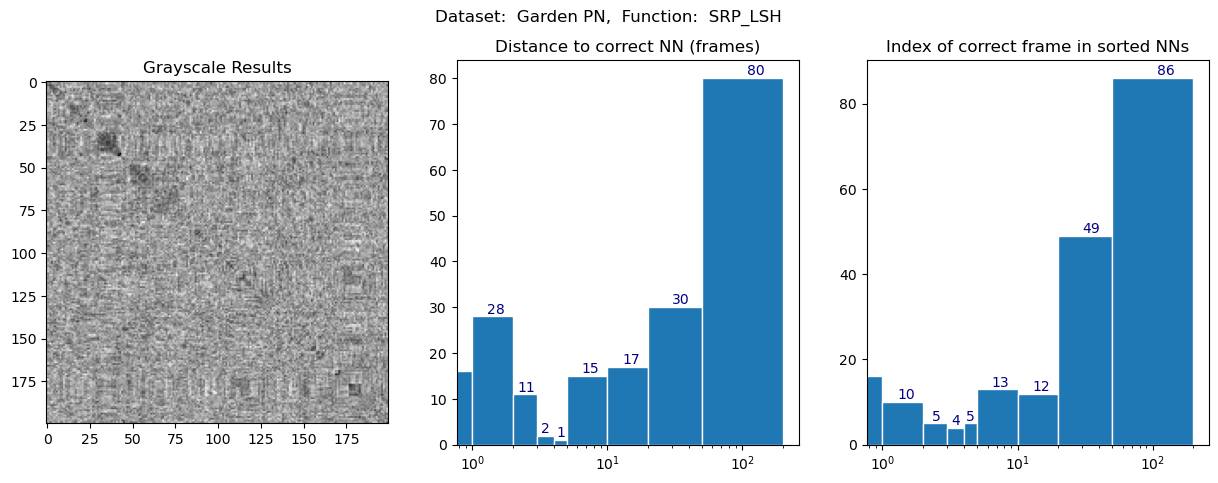

In [29]:
srp31pn, srp32pn, srp33pn = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_2, Q_garden_2, "Garden PN", "SRP_LSH", False, 50)

Duration SRP_LSH: 127.02565441699699 seconds
Median Distance to GT-NN: 3.5
Average Distance to GT-NN: 27.975
Median Rank of GT-NN: 8.5
Average Rank of GT-NN: 38.015
80 out of 200 within top 5 NNs


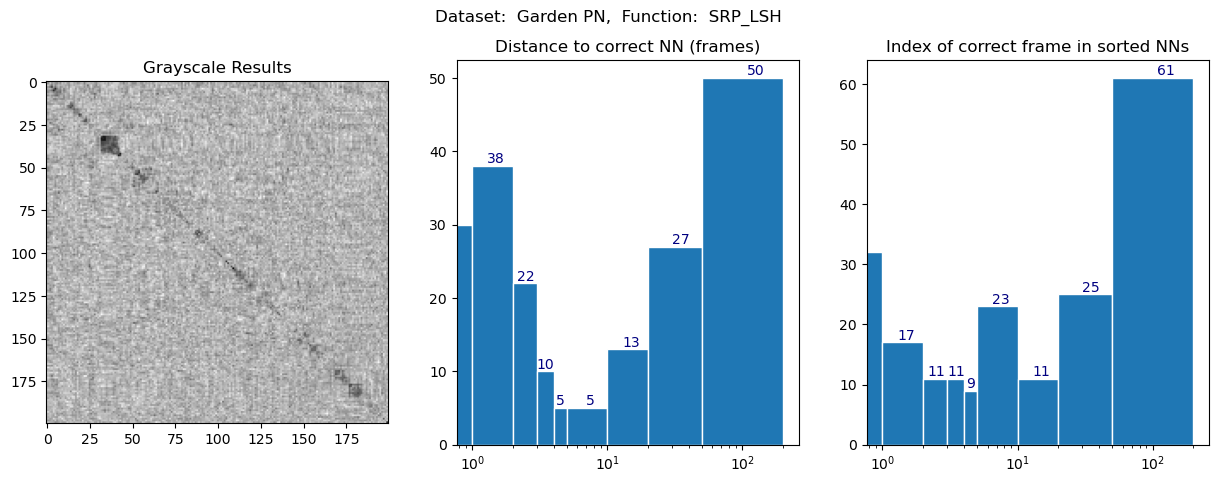

In [30]:
srp11pn, srp12pn, srp13pn = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_2, Q_garden_2, "Garden PN", "SRP_LSH", False, 200)

Duration SRP_LSH: 121.56325733300764 seconds
Median Distance to GT-NN: 2.0
Average Distance to GT-NN: 22.29
Median Rank of GT-NN: 7.5
Average Rank of GT-NN: 37.49
78 out of 200 within top 5 NNs


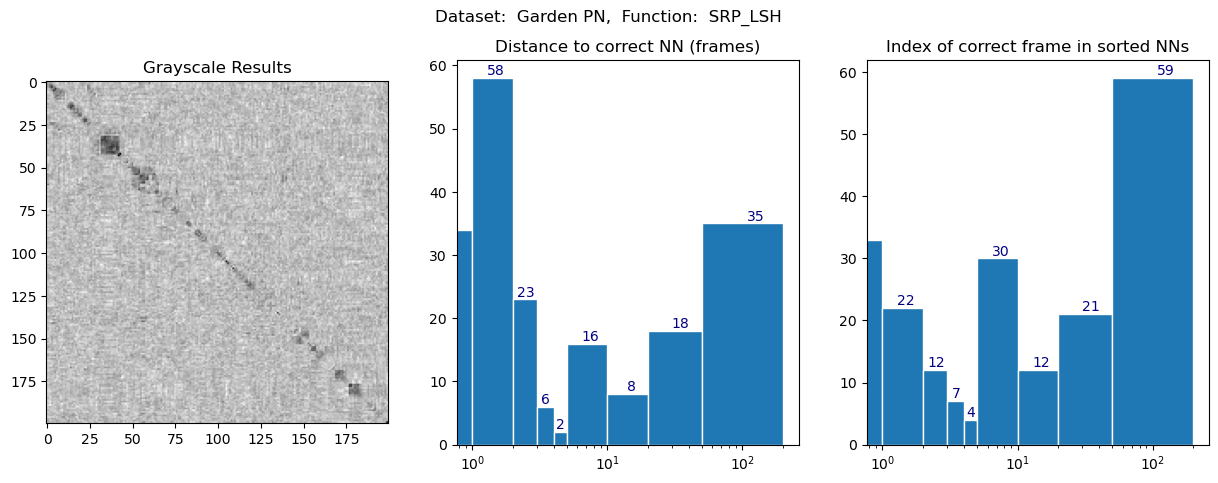

In [31]:
srp41pn, srp42pn, srp43pn = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_2, Q_garden_2, "Garden PN", "SRP_LSH", False, 360)

Duration SRP_LSH: 117.82750158396084 seconds
Median Distance to GT-NN: 1.5
Average Distance to GT-NN: 16.79
Median Rank of GT-NN: 5.0
Average Rank of GT-NN: 25.405
97 out of 200 within top 5 NNs


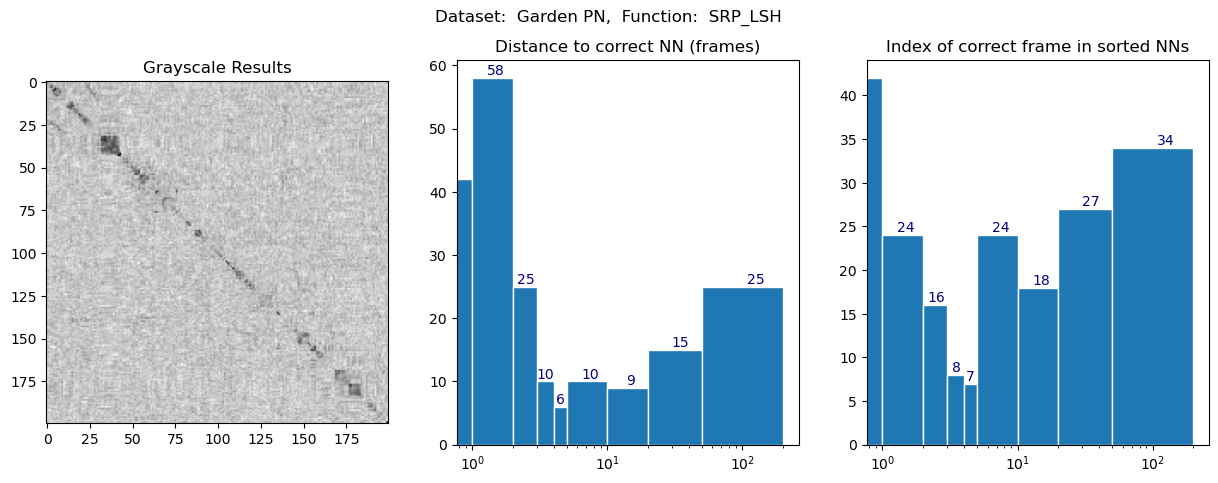

In [32]:
srp51pn, srp52pn, srp53pn = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_2, Q_garden_2, "Garden PN", "SRP_LSH", False, 540)

Duration SRP_LSH: 155.83150333398953 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 12.91
Median Rank of GT-NN: 4.0
Average Rank of GT-NN: 26.215
105 out of 200 within top 5 NNs


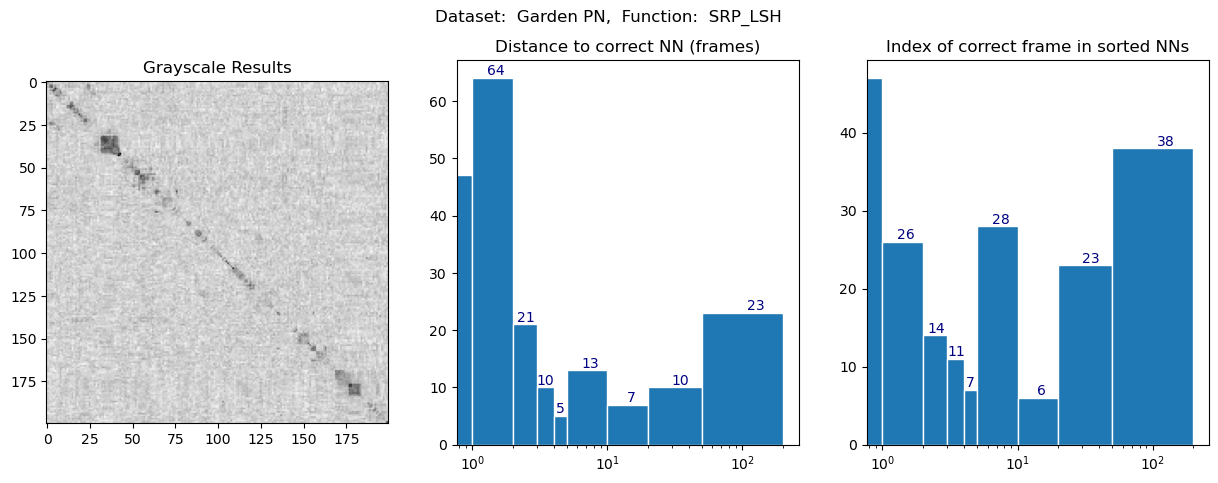

In [33]:
srp61pn, srp62pn, srp63pn = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_2, Q_garden_2, "Garden PN", "SRP_LSH", False, 720)

Duration SRP_LSH: 149.27131250000093 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 12.385
Median Rank of GT-NN: 4.0
Average Rank of GT-NN: 24.48
106 out of 200 within top 5 NNs


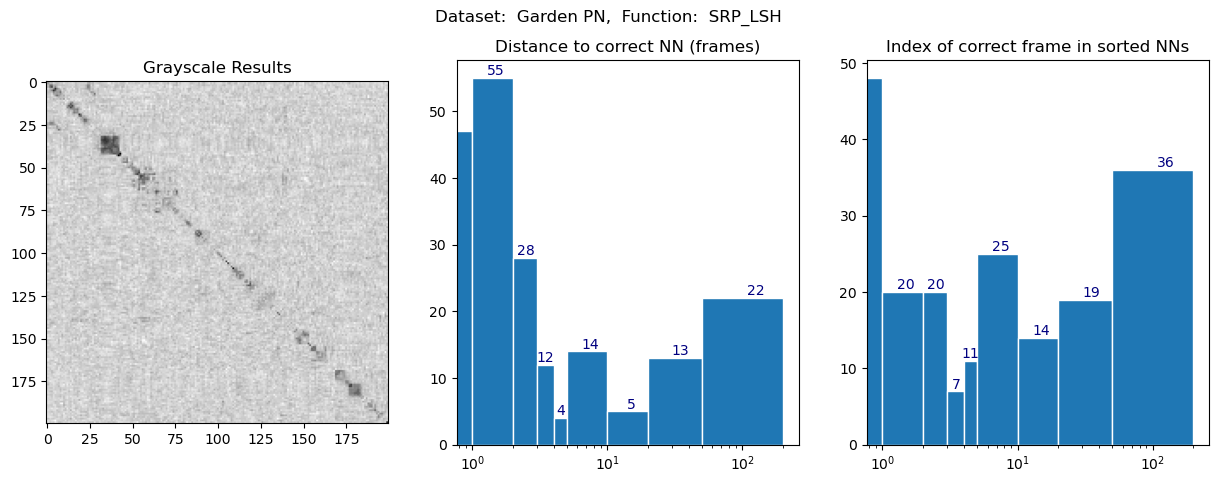

In [34]:
srp71pn, srp72pn, srp73pn = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_2, Q_garden_2, "Garden PN", "SRP_LSH", False, 900)

Duration SRP_LSH: 157.74055183306336 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 12.055
Median Rank of GT-NN: 3.0
Average Rank of GT-NN: 26.155
114 out of 200 within top 5 NNs


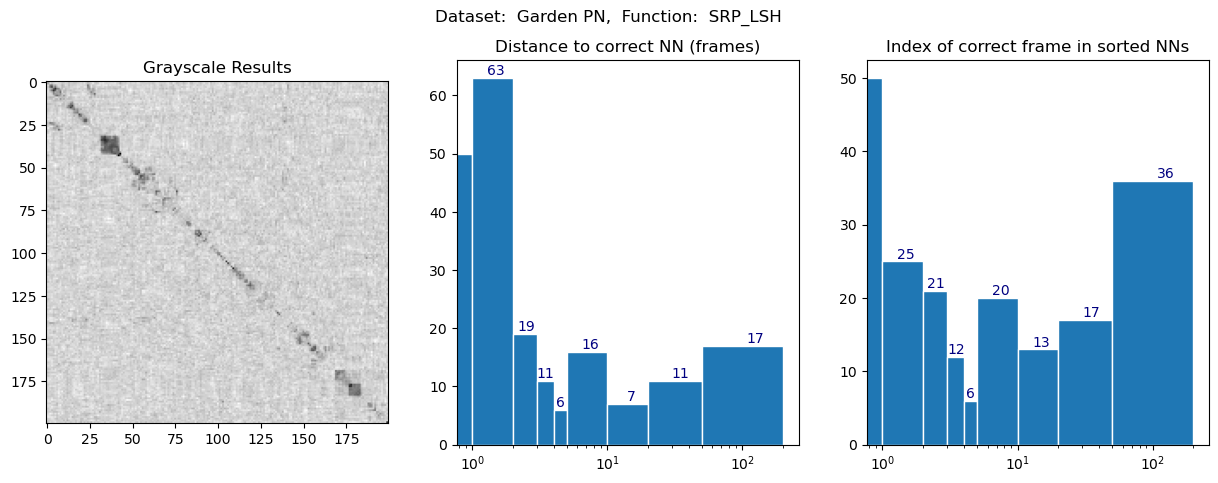

In [35]:
srp81pn, srp82pn, srp83pn = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_2, Q_garden_2, "Garden PN", "SRP_LSH", False, 1080)

Duration SRP_LSH: 177.06673433398828 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 10.45
Median Rank of GT-NN: 3.0
Average Rank of GT-NN: 23.77
112 out of 200 within top 5 NNs


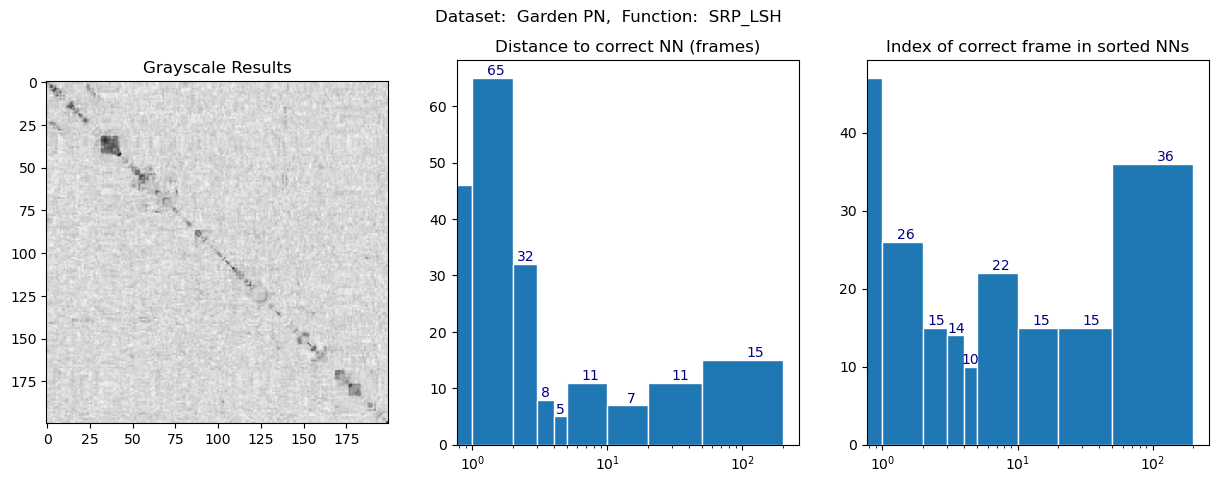

In [36]:
srp91pn, srp92pn, srp93pn = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_2, Q_garden_2, "Garden PN", "SRP_LSH", False, 1260)

Duration SRP_LSH: 289.3029213750269 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 10.22
Median Rank of GT-NN: 2.0
Average Rank of GT-NN: 18.03
119 out of 200 within top 5 NNs


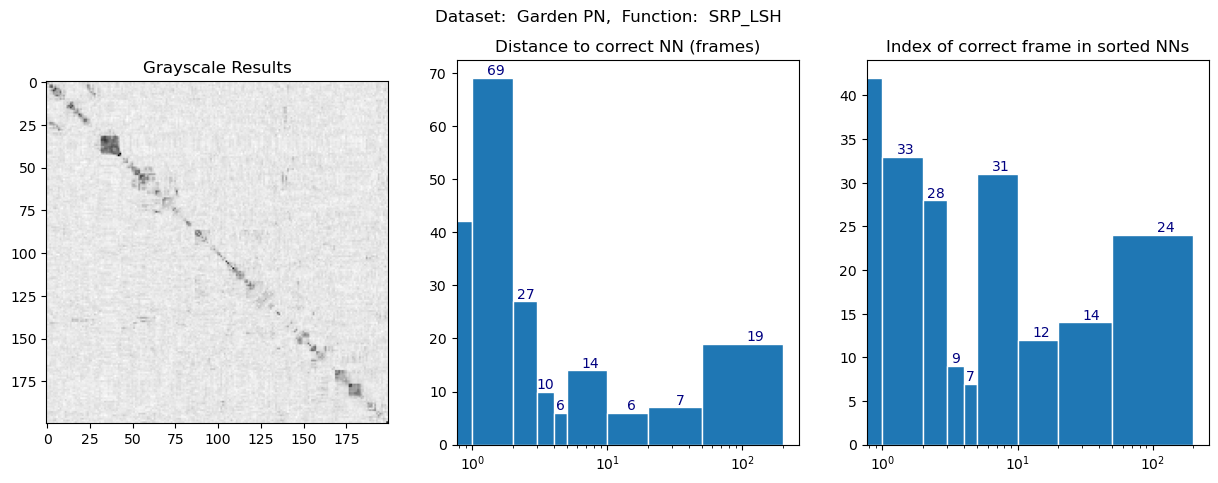

In [37]:
srp101pn, srp102pn, srp103pn = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_2, Q_garden_2, "Garden PN", "SRP_LSH", False, 3600)

Duration SRP_LSH: 329.32141175004654 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 9.635
Median Rank of GT-NN: 2.0
Average Rank of GT-NN: 15.81
122 out of 200 within top 5 NNs


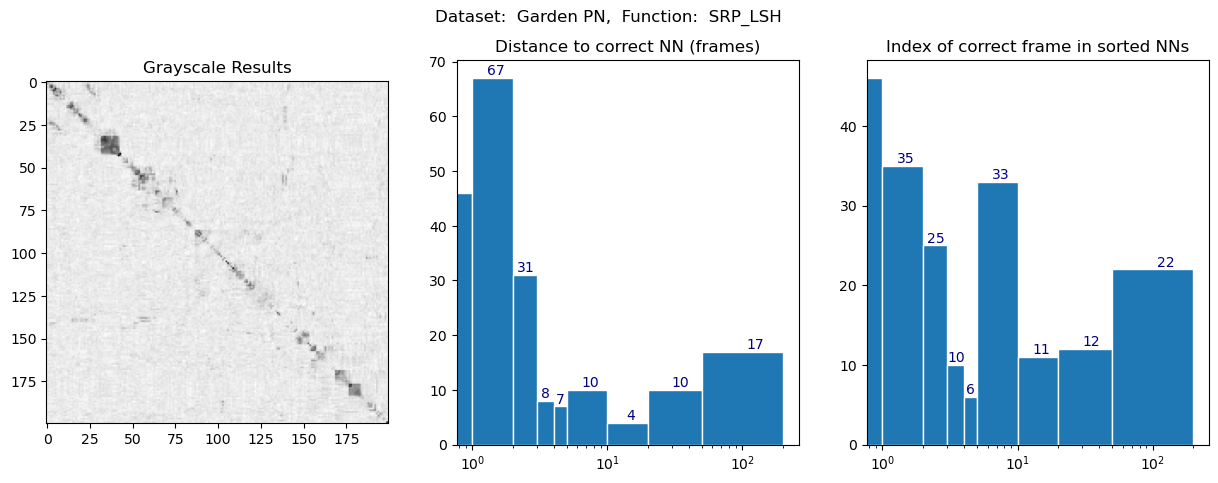

In [38]:
srp111pn, srp112pn, srp113pn = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, DS_garden_2, Q_garden_2, "Garden PN", "SRP_LSH", False, 5400)

In [15]:
#https://gist.github.com/iizukak/1287876/edad3c337844fac34f7e56ec09f9cb27d4907cc7

def gram_schmidt_columns(vectors):
    basis = []
    for v in vectors:
        w = v - np.sum( np.dot(v,b)*b  for b in basis )
        if (w > 1e-10).any():  
            basis.append(w/np.linalg.norm(w))
    return np.array(basis)

In [16]:
def srp_lsh_sequential_with_gs(Xin, Yin, num_rand_vectors):
    result_Matrix = np.zeros((Xin.shape[0], Yin.shape[0]), dtype=np.float32)
    d = Xin.shape[1]
    mu = np.zeros(d)
    cov_matrix = np.eye(d)
    rand_vectors_temp = np.random.multivariate_normal(mu, cov_matrix, num_rand_vectors)
    rand_vectors = gram_schmidt_columns(rand_vectors_temp)
    for i in range(Xin.shape[0]):
        vec1 = Xin[i].toarray()
        ##vec1 = vec1.reshape(1, vec1.size)
        for j in range(Yin.shape[0]):
            if i > j:
                similarity = result_Matrix[i][j]
            else:
                #compute similarity
                vec2 = Yin[j].toarray()
                #vec2 = vec2.reshape(1, vec2.size)
                code1 = (np.dot(vec1, np.transpose(rand_vectors)) >= 0)[0]
                code2 = (np.dot(vec2, np.transpose(rand_vectors)) >= 0)[0]
                similarity = distance.hamming(code1, code2)
            result_Matrix[j][i] = similarity
    return result_Matrix

/var/folders/ps/mj99w1213zg0w0ymxdbjl9sr0000gn/T/ipykernel_69337/1603164824.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  w = v - np.sum( np.dot(v,b)*b  for b in basis )


Duration SRP_LSH: 376.5076612079283 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 9.385
Median Rank of GT-NN: 2.0
Average Rank of GT-NN: 13.99
133 out of 200 within top 5 NNs


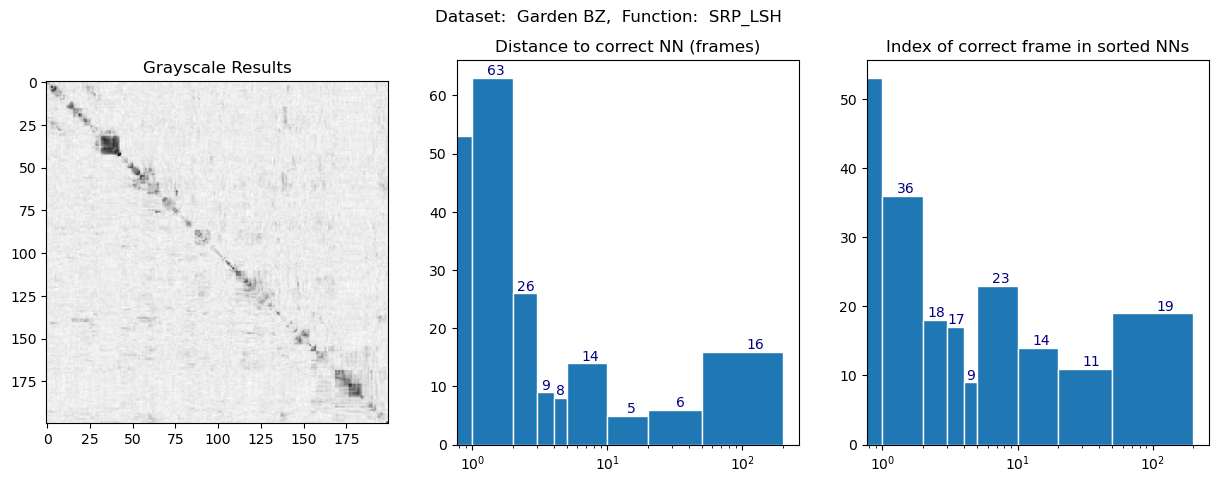

In [17]:
srp111, srp112, srp113 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential_with_gs, DS_garden_1, Q_garden_1, "Garden BZ", "SRP_LSH", False, 5400)

/var/folders/ps/mj99w1213zg0w0ymxdbjl9sr0000gn/T/ipykernel_69337/1603164824.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  w = v - np.sum( np.dot(v,b)*b  for b in basis )


Duration SRP_LSH: 509.9312718330184 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 9.55
Median Rank of GT-NN: 2.0
Average Rank of GT-NN: 16.345
122 out of 200 within top 5 NNs


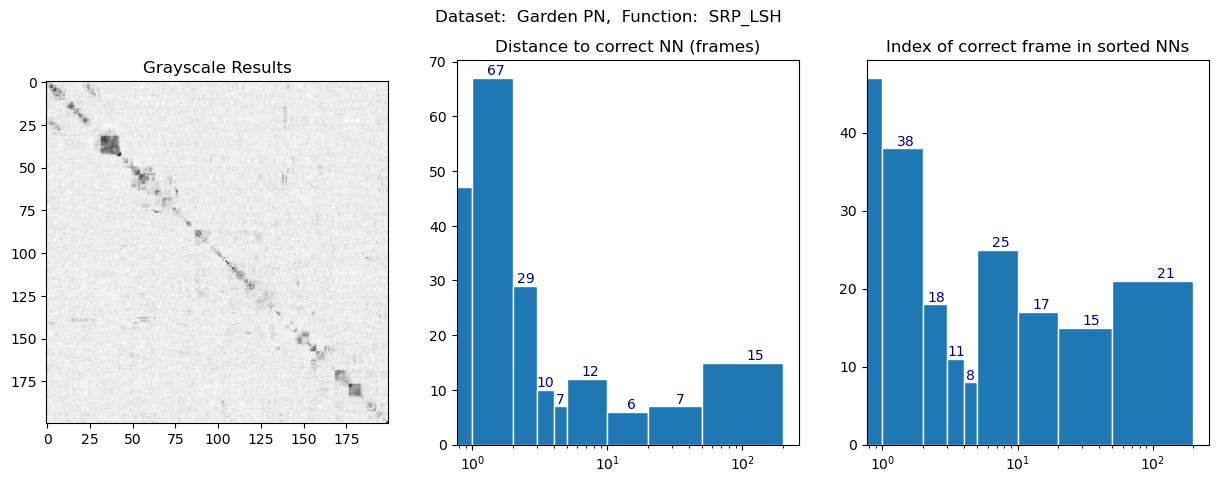

In [39]:
srp111, srp112, srp113 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential_with_gs, DS_garden_2, Q_garden_2, "Garden PN", "SRP_LSH", False, 5400)

Duration SRP_LSH: 35338.50612379203 seconds
Median Distance to GT-NN: 0.0
Average Distance to GT-NN: 96.581
Median Rank of GT-NN: 0.0
Average Rank of GT-NN: 45.911
784 out of 1000 within top 5 NNs


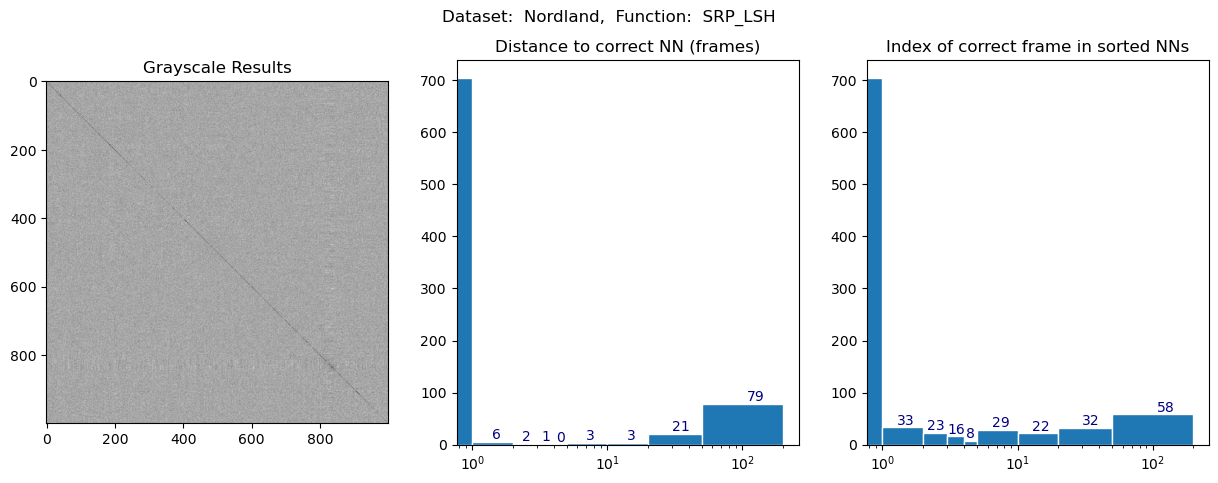

In [42]:
nl_srp11, nl_srp12, nl_srp13 = nnt.run_and_evaluate_func_on_data(srp_lsh_sequential, nl_spring_seer, nl_winter_seer, "Nordland", "SRP_LSH", False, 100)

In [9]:
import numpy as np
from time import perf_counter

num_rand_vectors = 3600
d = 1625
mu = np.zeros(d)
cov_matrix = np.eye(d)
start = perf_counter()
rand_vectors_temp = np.random.multivariate_normal(mu, cov_matrix, num_rand_vectors)
end = perf_counter()
duration = end - start

print(duration)

1.2986309999832883


In [10]:
import numpy as np
from time import perf_counter

num_rand_vectors = 3600
d = 3250
mu = np.zeros(d)
cov_matrix = np.eye(d)
start = perf_counter()
rand_vectors_temp = np.random.multivariate_normal(mu, cov_matrix, num_rand_vectors)
end = perf_counter()
duration = end - start

print(duration)

21.42315608402714


In [11]:
import numpy as np
from time import perf_counter

num_rand_vectors = 3600
d = 6500
mu = np.zeros(d)
cov_matrix = np.eye(d)
start = perf_counter()
rand_vectors_temp = np.random.multivariate_normal(mu, cov_matrix, num_rand_vectors)
end = perf_counter()
duration = end - start

print(duration)

68.2674472500803


In [12]:
import numpy as np
from time import perf_counter

num_rand_vectors = 3600
d = 13000
mu = np.zeros(d)
cov_matrix = np.eye(d)
start = perf_counter()
rand_vectors_temp = np.random.multivariate_normal(mu, cov_matrix, num_rand_vectors)
end = perf_counter()
duration = end - start

print(duration)

385.41206595802214


In [13]:
import numpy as np
from time import perf_counter

num_rand_vectors = 1800
d = 6500
mu = np.zeros(d)
cov_matrix = np.eye(d)
start = perf_counter()
rand_vectors_temp = np.random.multivariate_normal(mu, cov_matrix, num_rand_vectors)
end = perf_counter()
duration = end - start

print(duration)

61.77659704198595


In [14]:
import numpy as np
from time import perf_counter

num_rand_vectors = 5400
d = 6500
mu = np.zeros(d)
cov_matrix = np.eye(d)
start = perf_counter()
rand_vectors_temp = np.random.multivariate_normal(mu, cov_matrix, num_rand_vectors)
end = perf_counter()
duration = end - start

print(duration)

86.73566858307458


In [15]:
import numpy as np
from time import perf_counter

num_rand_vectors = 7200
d = 6500
mu = np.zeros(d)
cov_matrix = np.eye(d)
start = perf_counter()
rand_vectors_temp = np.random.multivariate_normal(mu, cov_matrix, num_rand_vectors)
end = perf_counter()
duration = end - start

print(duration)

79.23145129194017


In [16]:
import numpy as np
from time import perf_counter

num_rand_vectors = 9000
d = 6500
mu = np.zeros(d)
cov_matrix = np.eye(d)
start = perf_counter()
rand_vectors_temp = np.random.multivariate_normal(mu, cov_matrix, num_rand_vectors)
end = perf_counter()
duration = end - start

print(duration)

74.50777083297726


In [25]:
DS_garden_1[0].nonzero()[1][6]

6

In [7]:
indices_lists = [[] for _ in range(DS_garden_1.shape[1])]
for i in range(DS_garden_1.shape[0]):
    vec = DS_garden_1[i]
    #get populated dimensions
    used_dims = vec.nonzero()[1]
    for dim in used_dims:
        indices_lists[dim].append(i)
    

In [12]:
start = perf_counter()
indices_lists_nl = [[] for _ in range(nl_spring_seer.shape[1])]
for i in range(nl_spring_seer.shape[0]):
    vec = nl_spring_seer[i]
    #get populated dimensions
    used_dims = vec.nonzero()[1]
    for dim in used_dims:
        indices_lists_nl[dim].append(i)
end = perf_counter()
duration = end - start

In [13]:
duration

0.6326905830064788

In [14]:
nonzero_indices = np.array([4,78,93,104,109])

In [42]:
cand = [indices_lists_nl[i] for i in nonzero_indices]

In [45]:
cand.flatten()

AttributeError: 'list' object has no attribute 'flatten'

In [15]:
# Wandelt die Liste in ein NumPy-Array um
indices_array = np.array(indices_lists_nl, dtype=object)  # dtype=object für Listen

# Jetzt kannst du mit NumPy erweiterte Indexierung verwenden
selected_indices = indices_array[nonzero_indices]

In [18]:
from itertools import chain

In [26]:
selected_indices[:,0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [31]:
selected_indices

array([list([0]), list([1, 176]), list([0, 1, 59, 176]), list([2]),
       list([2, 3, 197])], dtype=object)

In [15]:
combined_list = [item for sublist in selected_indices for item in sublist]
unique_elements = list(set(combined_list))

In [7]:
np.array(unique_elements)

NameError: name 'unique_elements' is not defined

In [45]:
selected_indices

array([list([0, 1, 2, 3, 4, 154]), list([3, 4, 5, 6]), list([3, 4, 5]),
       list([4, 5, 6]), list([4, 5, 6])], dtype=object)

Duration Count Common Dimensions: 1.3806677079992369 seconds
Median Distance to GT-NN: 2.0
Average Distance to GT-NN: 10.405
Median Rank of GT-NN: 3.0
Average Rank of GT-NN: 11.915
122 out of 200 within top 5 NNs


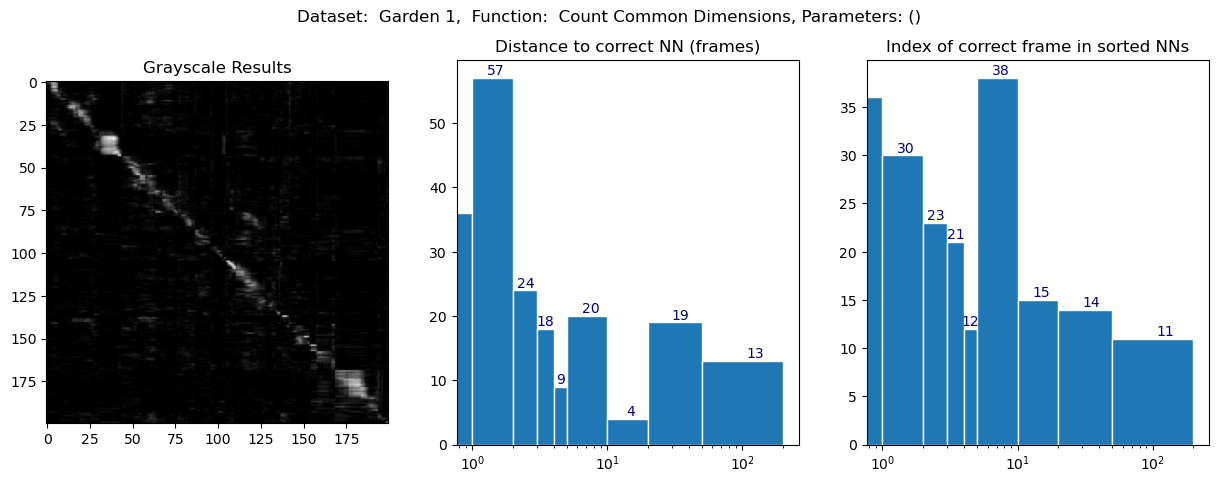

In [5]:
r, rdh, rr = nnt.run_and_evaluate_func_on_data(nnt.compute_matching_dimensions_w_index, DS_garden_1, Q_garden_1, "Garden 1", "Count Common Dimensions", True)

Duration Count Common Dimensions with Index: 104.85878970799968 seconds
Median Distance to GT-NN: 0.0
Average Distance to GT-NN: 28.608
Median Rank of GT-NN: 0.0
Average Rank of GT-NN: 6.556
949 out of 1000 within top 5 NNs


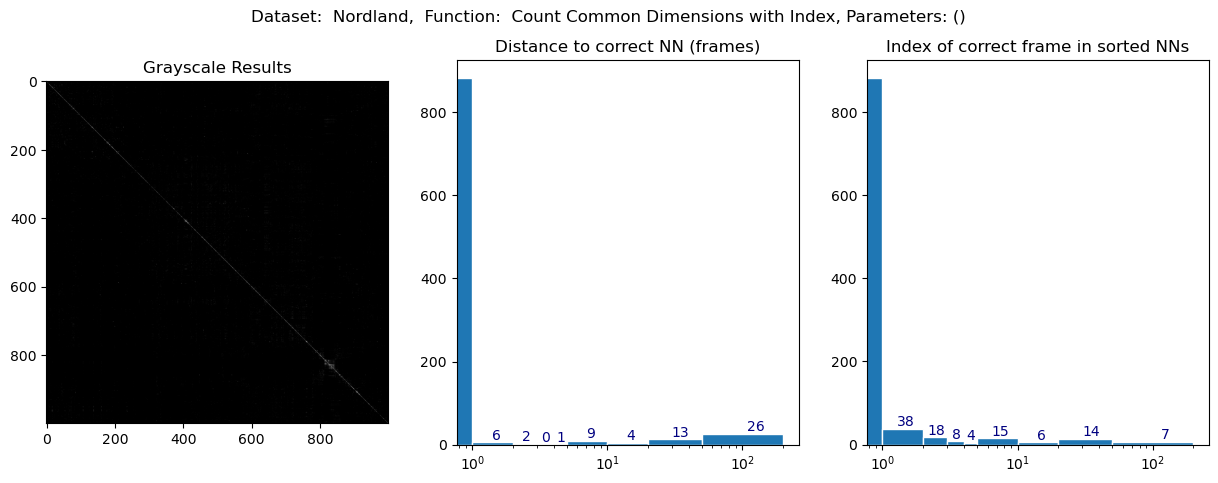

In [6]:
r, rdh, rr = nnt.run_and_evaluate_func_on_data(nnt.compute_matching_dimensions_w_index, nl_spring_seer, nl_winter_seer, "Nordland", "Count Common Dimensions with Index", True)

Duration Count Common Dimensions with Index: 1.0963519579963759 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 8.21
Median Rank of GT-NN: 3.0
Average Rank of GT-NN: 13.38
123 out of 200 within top 5 NNs


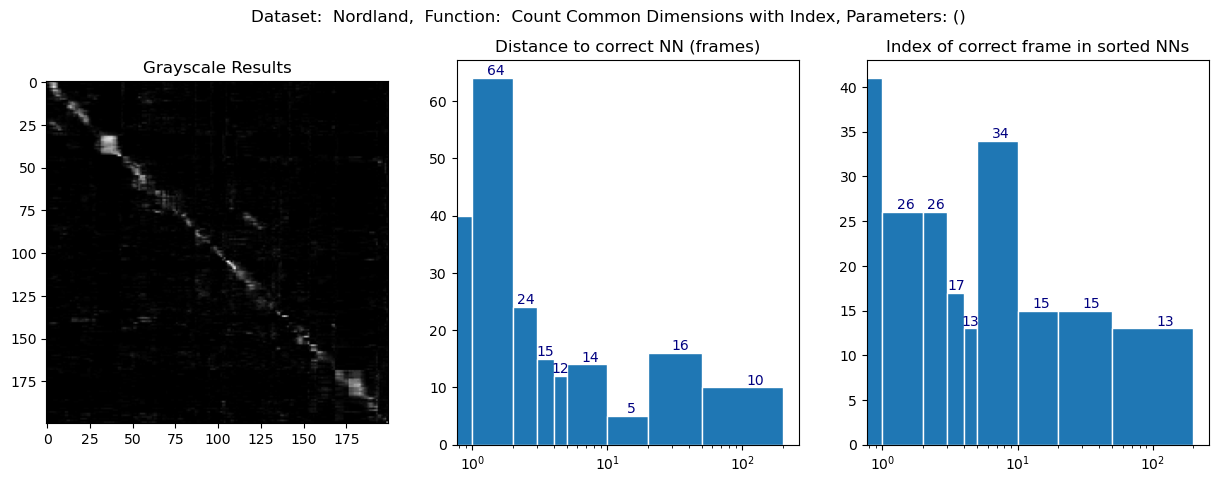

In [37]:
r, rdh, rr = nnt.run_and_evaluate_func_on_data(nnt.compute_matching_dimensions_w_index, DS_garden_2, Q_garden_2, "Garden2", "Count Common Dimensions with Index", True)

Duration Count Common Dimensions: 1.6109277920331806 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 9.345
Median Rank of GT-NN: 2.0
Average Rank of GT-NN: 11.81
132 out of 200 within top 5 NNs


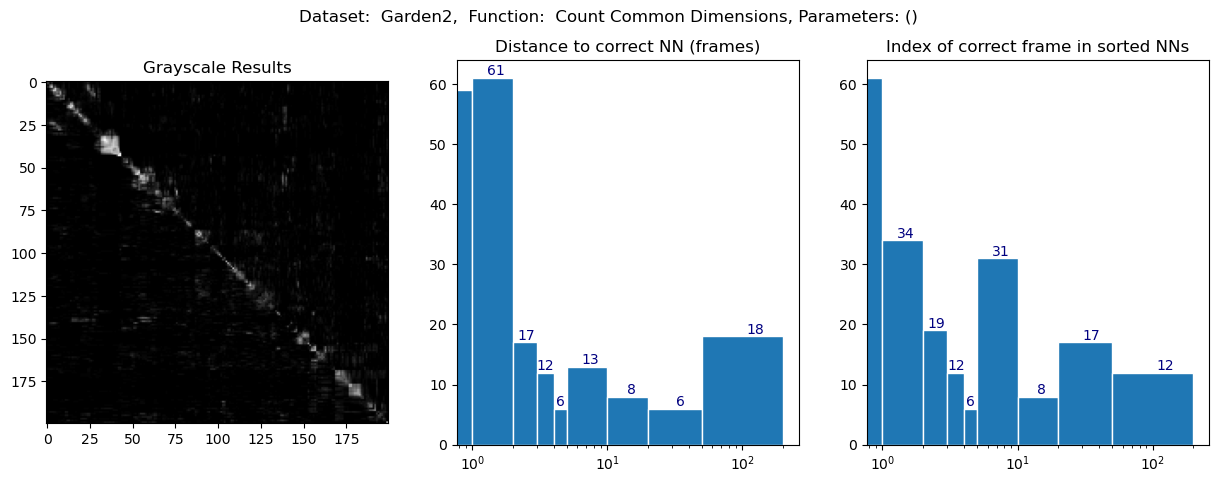

In [39]:
r, rdh, rr = nnt.run_and_evaluate_func_on_data(nnt.compute_matching_dimensions_sequential, DS_garden_2, Q_garden_2, "Garden2", "Count Common Dimensions", True)

In [41]:
np.size(np.intersect1d(np.array([2,3,44]), np.array([1,5])))

0

In [64]:
indices_list = nnt.build_index_structure_matching_dims(Q_garden_1)

In [70]:
Q_garden_1[0,2157]

0.020431338

In [74]:
indices_list = nnt.build_index_structure_matching_dims(Q_garden_1)

In [75]:
nonzero_160 = DS_garden_1[160].nonzero()[1]

In [77]:
indices_array = np.array(indices_list, dtype=object)
candidates_ind = indices_array[nonzero_160]

In [79]:
flattened_list = [item for sublist in candidates_ind for item in sublist]

In [82]:
from collections import Counter
counter = Counter(flattened_list)

In [83]:
count_of_160 = counter[160]

In [99]:
counter[158]

45

In [84]:
count_of_160

10

In [89]:
def build_index_structure_matching_dims(Q_Data):
    indices_lists = [[] for _ in range(Q_Data.shape[1])]
    for i in range(Q_Data.shape[0]):
        vec = Q_Data[i]
        #get populated dimensions
        used_dims = vec.nonzero()[1]
        for dim in used_dims:
            indices_lists[dim].append(i)
    return indices_lists

In [86]:
from collections import Counter
def compute_matching_dimensions_w_index_test(Xin, Yin):
        result_Matrix = np.zeros((Xin.shape[0], Yin.shape[0]), dtype=np.float32)
        indices_lists = build_index_structure_matching_dims(Yin)
        indices_array = np.array(indices_lists, dtype=object)  # dtype=object für Listen
        for i in range(Xin.shape[0]):
            #get nonzero Elements of descriptor
            nonzero_dims = Xin[i].nonzero()[1]
            candidates_ind = indices_array[nonzero_dims]
            flattened_list = [item for sublist in candidates_ind for item in sublist]
            counter = Counter(flattened_list)
            #combined_list = [item for sublist in candidates_ind for item in sublist]
            #unique_elements = np.array(list(set(combined_list)))
            #if unique_elements.size == 0:
                #continue
            for index, count in counter.items():   
                #matches = np.size(get_common_indices(Xin[i], Yin[j]))
                result_Matrix[index][i] = count
        return result_Matrix

Duration Count Common Dimensions: 1.6203799590002745 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 9.345
Median Rank of GT-NN: 2.0
Average Rank of GT-NN: 11.81
132 out of 200 within top 5 NNs


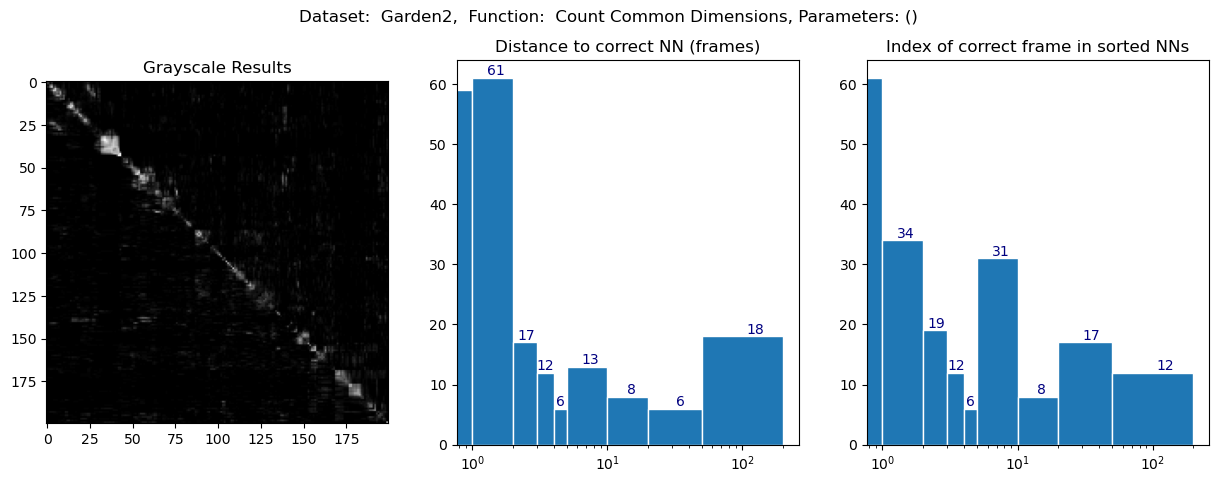

In [87]:
r, rdh, rr = nnt.run_and_evaluate_func_on_data(nnt.compute_matching_dimensions_sequential, DS_garden_2, Q_garden_2, "Garden2", "Count Common Dimensions", True)

Duration Count Common Dimensions: 0.05582262494135648 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 8.21
Median Rank of GT-NN: 3.0
Average Rank of GT-NN: 13.38
123 out of 200 within top 5 NNs


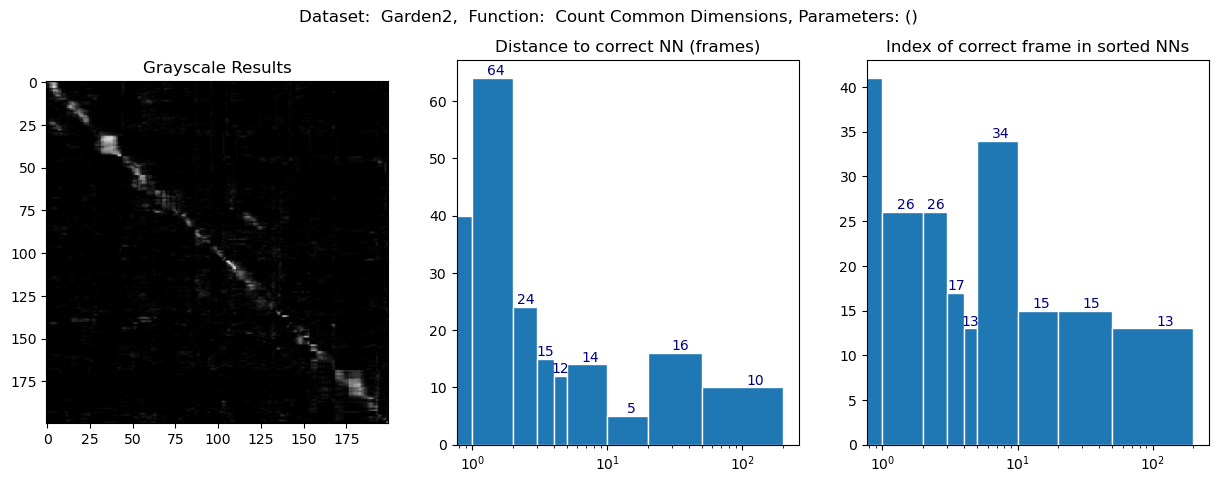

In [90]:
r, rdh, rr = nnt.run_and_evaluate_func_on_data(compute_matching_dimensions_w_index_test, DS_garden_2, Q_garden_2, "Garden2", "Count Common Dimensions", True)

Duration Count Common Dimensions with Index: 1.2781971669755876 seconds
Median Distance to GT-NN: 0.0
Average Distance to GT-NN: 28.608
Median Rank of GT-NN: 0.0
Average Rank of GT-NN: 6.556
949 out of 1000 within top 5 NNs


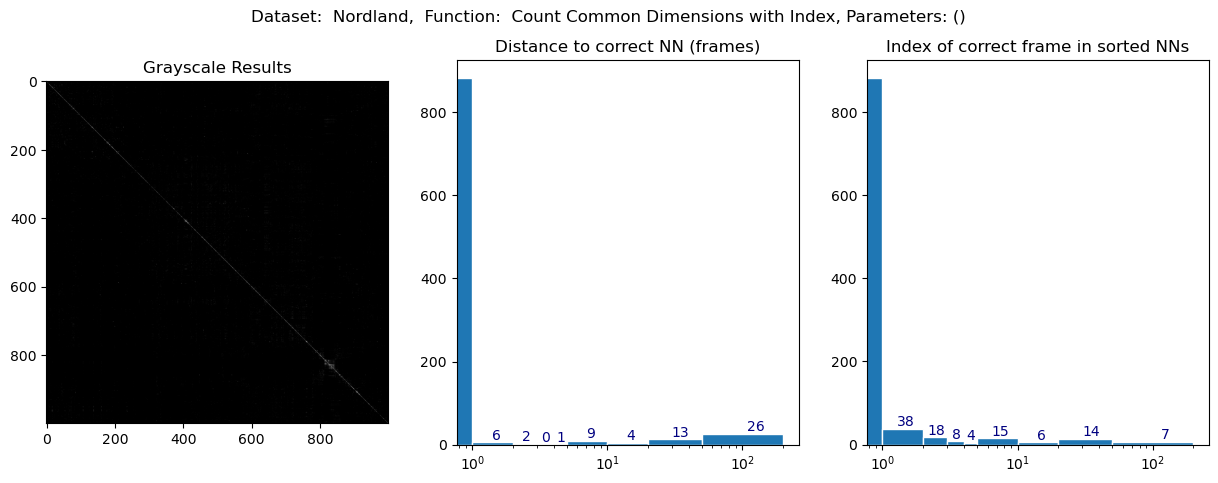

In [91]:
r, rdh, rr = nnt.run_and_evaluate_func_on_data(compute_matching_dimensions_w_index_test, nl_spring_seer, nl_winter_seer, "Nordland", "Count Common Dimensions with Index", True)

In [97]:
def get_common_indices(sparsem1, sparsem2):
    return np.intersect1d(sparsem1.nonzero()[1],  sparsem2.nonzero()[1])

def compute_matching_dimensions_sequential_test(Xin, Yin):
        result_Matrix = np.zeros((Xin.shape[0], Yin.shape[0]), dtype=np.float32)
        for i in range(Xin.shape[0]):
            for j in range(Yin.shape[0]):
                #if i > j:
                    #matches = result_Matrix[i][j]
                #else:
                matches = np.size(get_common_indices(Xin[i], Yin[j]))
                result_Matrix[j][i] = matches
        return result_Matrix

Duration Count Common Dimensions: 3.1576672500232235 seconds
Median Distance to GT-NN: 1.0
Average Distance to GT-NN: 8.21
Median Rank of GT-NN: 3.0
Average Rank of GT-NN: 13.38
123 out of 200 within top 5 NNs


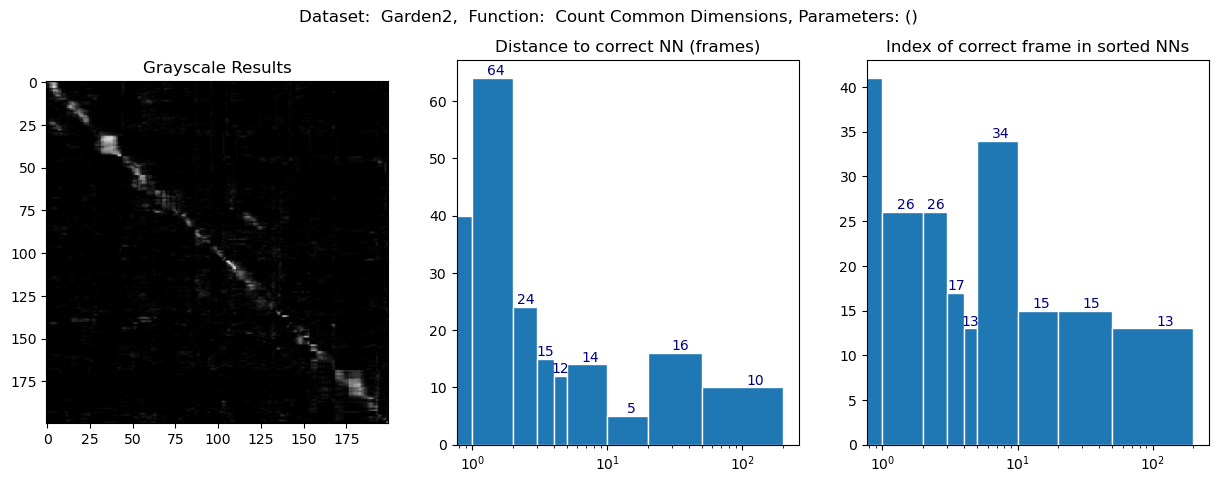

In [98]:
r, rdh, rr = nnt.run_and_evaluate_func_on_data(compute_matching_dimensions_sequential_test, DS_garden_2, Q_garden_2, "Garden2", "Count Common Dimensions", True)